In [133]:
#Mediante https://www.tensorflow.org/tutorials/structured_data/time_series
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from tensorflow.keras import layers
from keras.layers import Dense,LSTM
from keras.models import Sequential, Model

In [134]:
dataMeteoCellId5644 = pd.read_csv('transformed_data/mi_CellId_extra_info_10min_December_5644.csv', index_col=0)
dataMeteoCellId5644

week  weekday  hour  minute  CellID     smsin    smsout    callin  \
74       48        6     1       0    5644  4.212775  1.955709  0.388609   
80       48        6     1      10    5644  1.799319  0.605493  0.898670   
86       48        6     1      20    5644  1.990377  0.354464  0.331425   
92       48        6     1      30    5644  0.240589  0.118954  0.967023   
98       48        6     1      40    5644  2.553785  0.337123  1.610132   
...     ...      ...   ...     ...     ...       ...       ...       ...   
24242    52        6     0      20    5644  4.983078  4.126058  0.000000   
24248    52        6     0      30    5644  3.779156  2.233179  0.043089   
24254    52        6     0      40    5644  2.582291  3.227843  1.745399   
24260    52        6     0      50    5644  3.701950  3.957995  1.199242   
24266    52        6     1       0    5644  3.826925  3.207260  0.032797   

        callout    internet      idx  relativeHumidity  precipitation  \
74     0.953972  135.029209  49254.0              99.0            0.0   
80     0.299133  107.493371  49255.0              99.0            0.0   
86     0.129266  116.361533  49256.0              99.0            0.0   
92     0.070730  127.892932  49257.0              99.0            0.0   
98     0.000000  110.755299  49258.0              99.0            0.0   
...         ...         ...      ...               ...            ...   
24242  1.587627  170.734492  53282.0              99.0            0.0   
24248  0.000000  153.487745  53283.0              99.0            0.0   
24254  1.056442  157.522089  53284.0              99.0            0.0   
24260  0.000000  159.975281  53285.0              99.0            0.0   
24266  0.032797  144.458604  53286.0              99.0            0.0   

       temperature  windSpeed        CO        NO2          NO   Benzene  
74       -0.200000   0.366667  1.200000  57.900000  124.500000  0.071660  
80       -0.283333   0.405556  1.216667  58.866667  124.683333  0.075489  
86       -0.366667   0.444444  1.233333  59.833333  124.866667  0.079317  
92       -0.450000   0.483333  1.250000  60.800000  125.050000  0.083146  
98       -0.533333   0.522222  1.266667  61.766667  125.233333  0.086974  
...            ...        ...       ...        ...         ...       ...  
24242     6.733333   1.100000  1.500000  51.700000   88.500000  1.200000  
24248     6.700000   1.100000  1.500000  51.950000   86.500000  1.200000  
24254     6.666667   1.100000  1.500000  52.200000   84.500000  1.200000  
24260     6.633333   1.100000  1.500000  52.450000   82.500000  1.200000  
24266     6.600000   1.100000  1.500000  52.700000   80.500000  1.200000  

[4033 rows x 19 columns]

In [135]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(dataMeteoCellId5644)

In [136]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [137]:
TRAIN_SPLIT = 2823 #len(dataMeteoCellId5644) * 0.7

In [138]:
TRAIN_SPLIT

2823

In [139]:
tf.random.set_seed(0)

In [140]:
uni_data5644 = dataMeteoCellId5644['internet']
uni_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
uni_data5644.head()

idx
2166.0    135.029209
2167.0    107.493371
2168.0    116.361533
2169.0    127.892932
2170.0    110.755299
Name: internet, dtype: float64

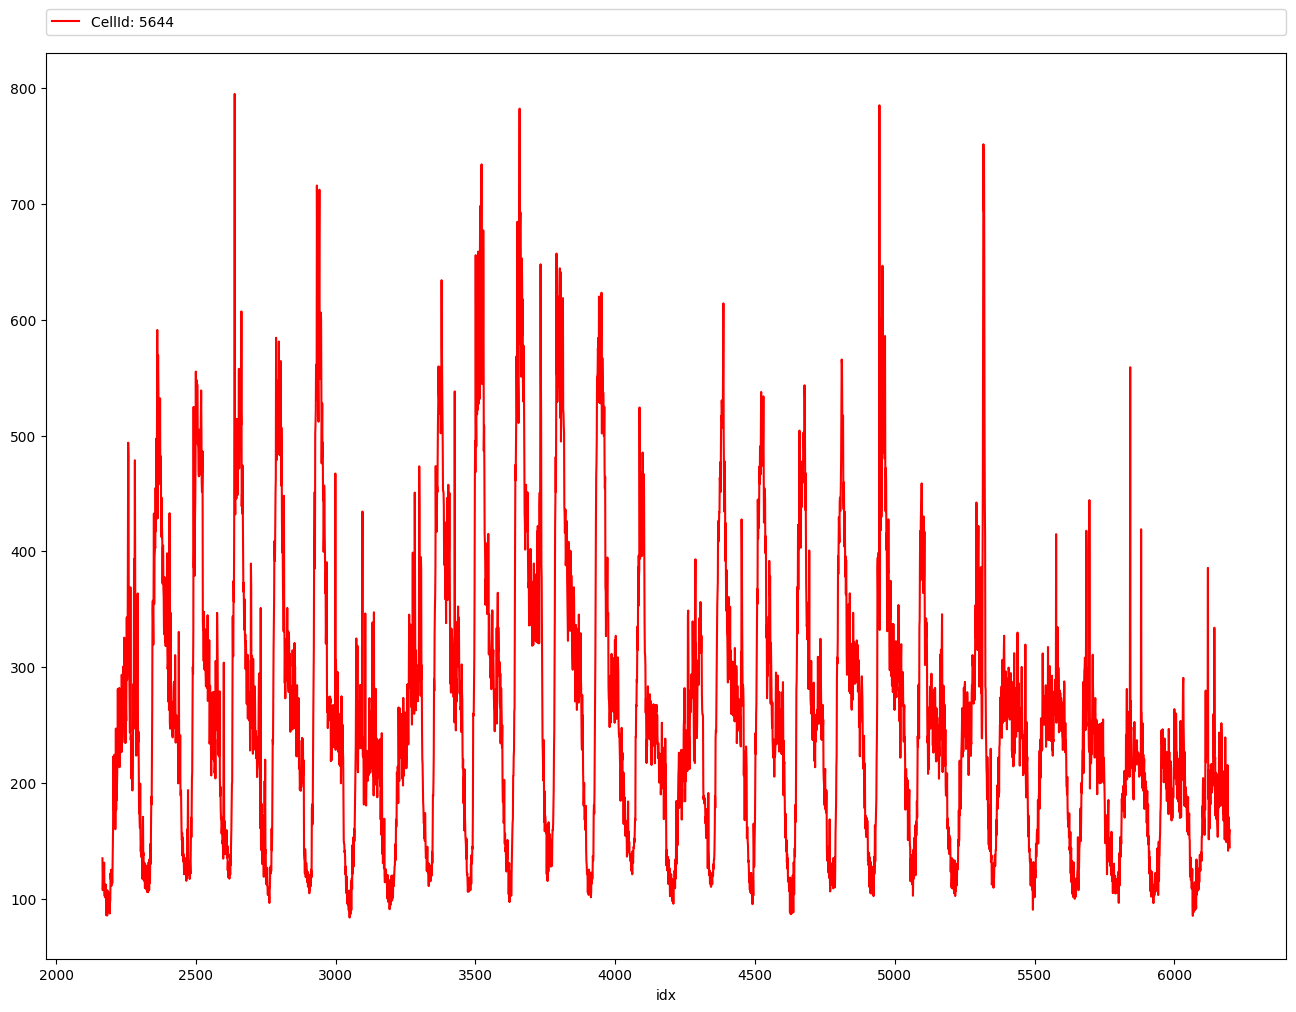

In [141]:
plt.figure(figsize=(16, 12), dpi=100) 

uni_data5644.plot(kind='line',x='index',y='internet', color='red', label = "CellId: 5644")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.savefig('Prueba.png',bbox_inches='tight')

plt.show()

In [142]:
uni_data = uni_data5644

<AxesSubplot:xlabel='idx'>

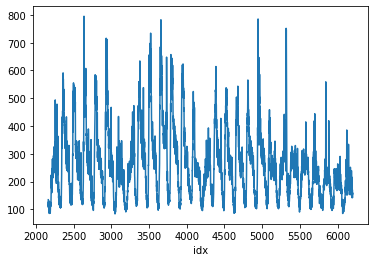

In [143]:
uni_data.plot()

In [144]:
uni_data

idx
2166.0    135.029209
2167.0    107.493371
2168.0    116.361533
2169.0    127.892932
2170.0    110.755299
             ...    
6194.0    170.734492
6195.0    153.487745
6196.0    157.522089
6197.0    159.975281
6198.0    144.458604
Name: internet, Length: 4033, dtype: float64

In [145]:
uni_data = uni_data.values

In [146]:
uni_data

array([135.02920893, 107.49337135, 116.36153292, ..., 157.52208874,
       159.97528053, 144.45860365])

In [147]:
uni_data
len(uni_data)

4033

In [148]:
from sklearn.preprocessing import MinMaxScaler
feature = ['idx', 'internet']
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(dataMeteoCellId5644[feature])

In [149]:
uni_data = DataScaledMeteoCellId5644

In [150]:
uni_data

array([[0.00000000e+00, 7.19307606e-02],
       [2.48015873e-04, 3.32120867e-02],
       [4.96031746e-04, 4.56817802e-02],
       ...,
       [9.99503968e-01, 1.03558434e-01],
       [9.99751984e-01, 1.07007914e-01],
       [1.00000000e+00, 8.51896149e-02]])

In [151]:
uni_data[:,1]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [152]:
univariate_past_history = 6
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(uni_data[:,1], 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data[:,1], TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [153]:
len(x_train_uni)

2817

In [154]:
len(y_train_uni)

2817

In [155]:
len(x_val_uni)

1203

In [156]:
x_train_uni

array([[[0.07193076],
        [0.03321209],
        [0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265]],

       [[0.03321209],
        [0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265],
        [0.06671302]],

       [[0.04568178],
        [0.0618963 ],
        [0.03779875],
        [0.04907265],
        [0.06671302],
        [0.03359665]],

       ...,

       [[0.40235302],
        [0.33817173],
        [0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ]],

       [[0.33817173],
        [0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ],
        [0.32088927]],

       [[0.3003    ],
        [0.37908385],
        [0.36254675],
        [0.4088272 ],
        [0.32088927],
        [0.30988734]]])

In [157]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target Internet charge to predict')
print (y_train_uni[0])

Single window of past history
[[0.07193076]
 [0.03321209]
 [0.04568178]
 [0.0618963 ]
 [0.03779875]
 [0.04907265]]

 Target Internet charge to predict
0.03359665147127812


In [158]:
def create_time_steps(length):
    return list(range(-length, 0))

In [159]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+3)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\envs\\gputensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

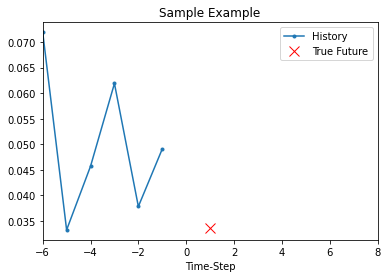

In [160]:
show_plot([x_train_uni[0], y_train_uni[0]], 1, 'Sample Example')

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\envs\\gputensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

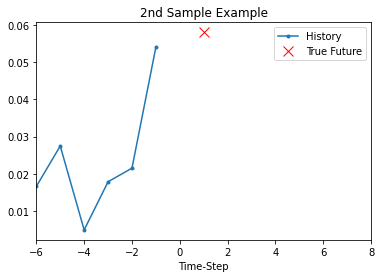

In [161]:
show_plot([x_train_uni[24], y_train_uni[24]], 1, '2nd Sample Example')

# Recurrent neural network con cambio de variables con la CellId 5644 -LSTM

In [162]:
EPOCHS = [100]
BATCH_SIZE = [128]
NODOS = [16]
LAYERS = [4]
LEARNINGRATE = [0.002]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_lstm_s = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm_s.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm_s.add(tf.keras.layers.LSTM(nodo))
                simple_lstm_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm_s.summary()

                simple_lstm_s.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_lstm_s = simple_lstm_s.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_lstm_s.evaluate(x_train_uni, y_train_uni, verbose=1)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_lstm_s = simple_lstm_s.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_lstm_s).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_lstm_s).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 100batch: 128nodos: 16layer: 4
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 6, 16)             1152      
_________________________________________________________________
lstm_13 (LSTM)               (None, 6, 16)             2112      
_________________________________________________________________
lstm_14 (LSTM)               (None, 6, 16)             2112      
_________________________________________________________________
lstm_15 (LSTM)               (None, 16)                2112      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 7s 285ms/step - loss: 0.06

In [31]:
test_predictions_lstm_s

array([[0.29858625],
       [0.3331825 ],
       [0.33092946],
       ...,
       [0.13347271],
       [0.13396281],
       [0.13759056]], dtype=float32)

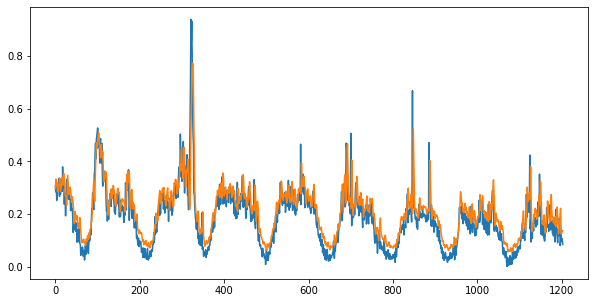

In [32]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_s)
plt.show()

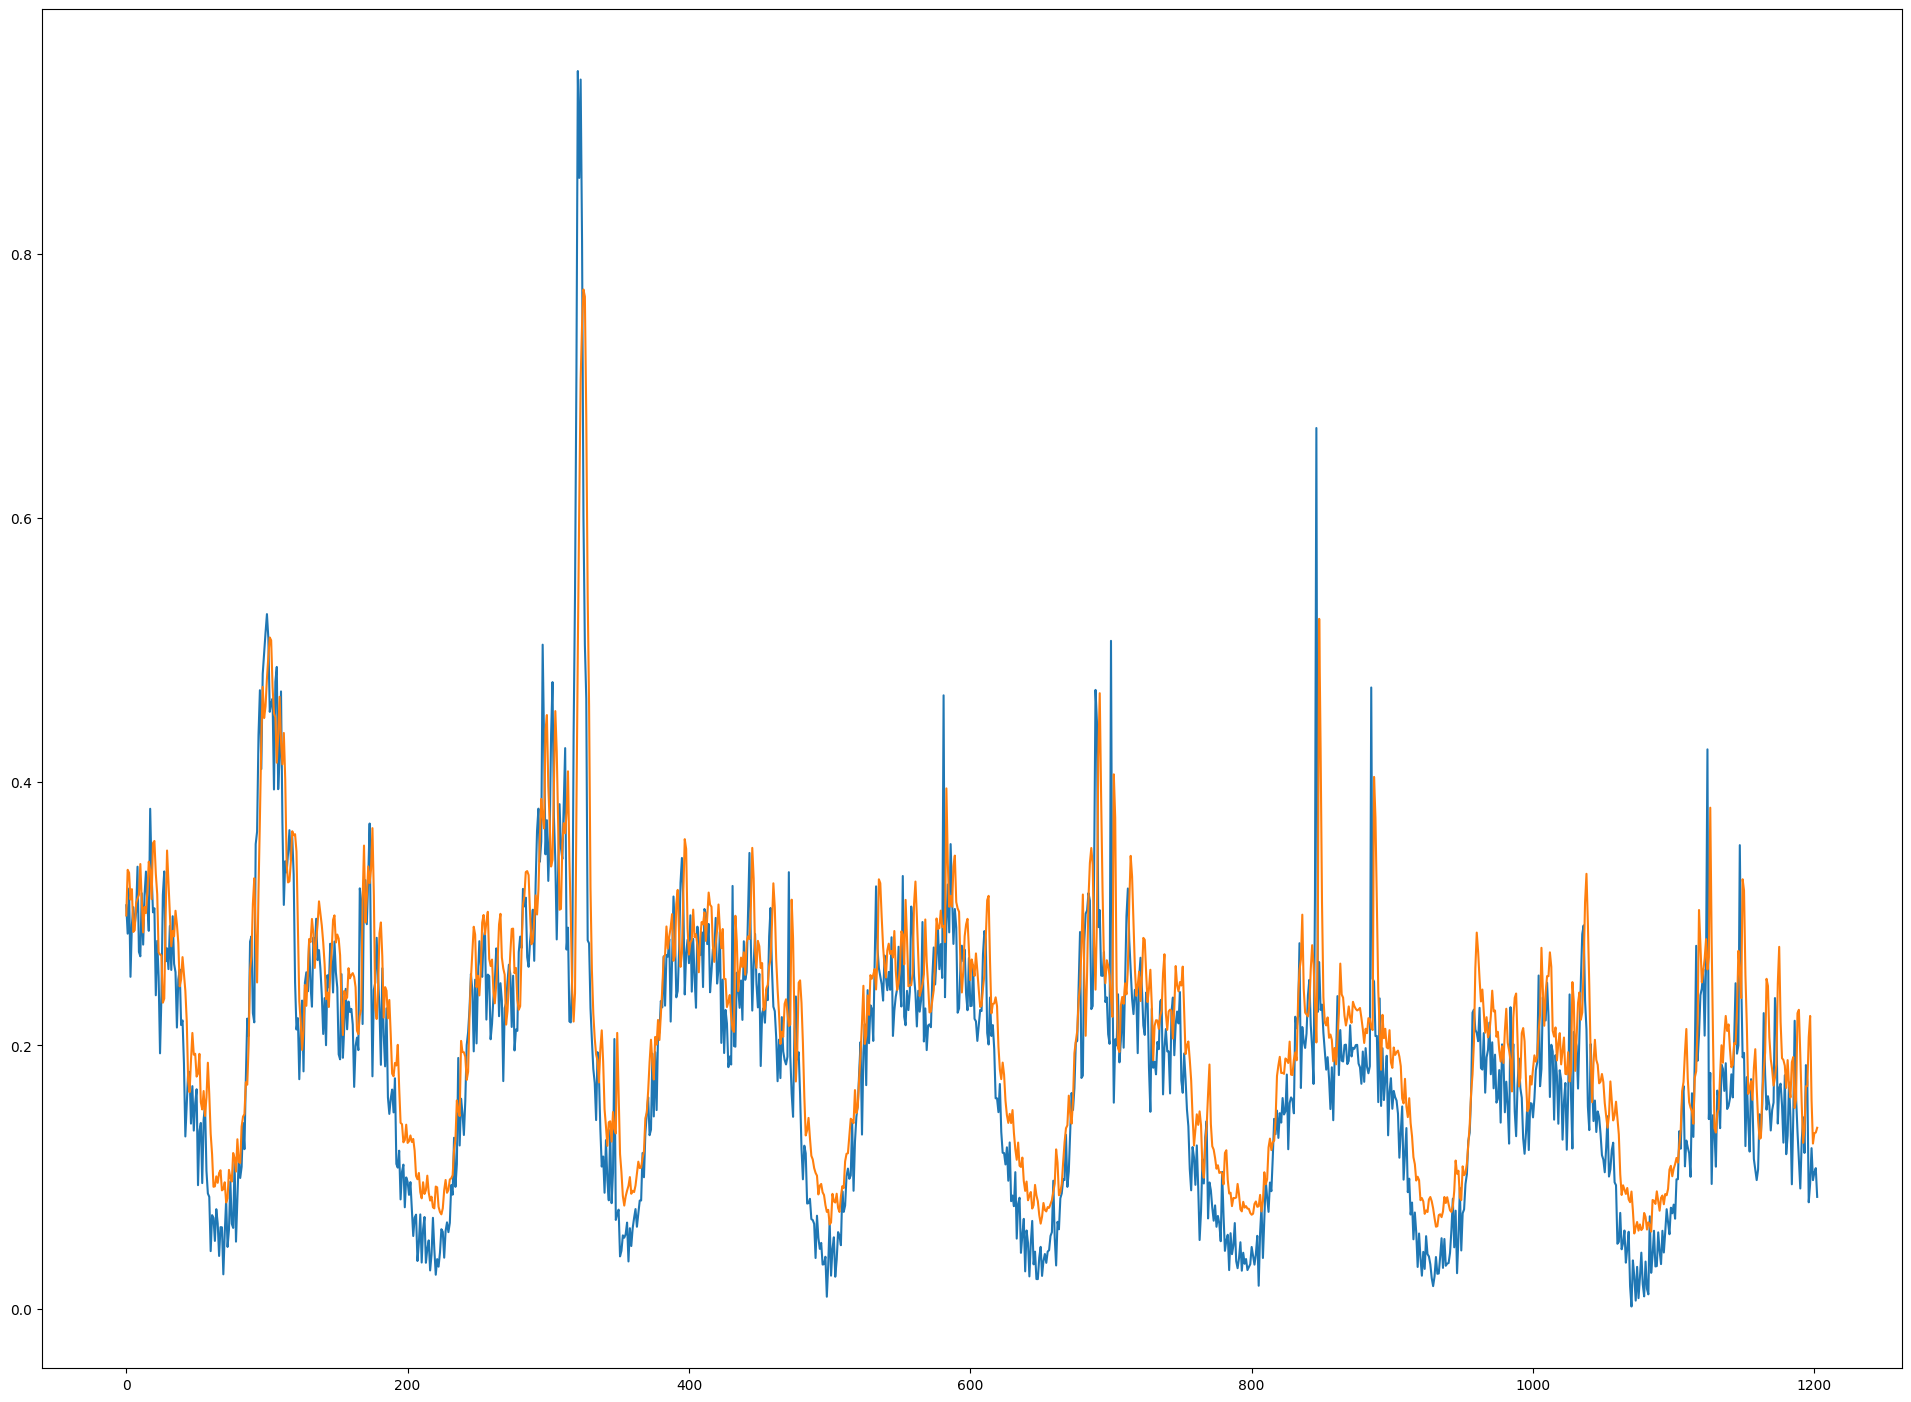

In [33]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_s)
plt.savefig('transformed_data/images/BEST-5644-6-0-1-LSTM.png',bbox_inches='tight')
plt.show()

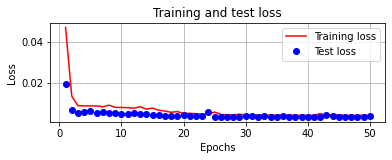

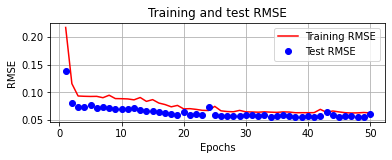

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_lstm_s.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_lstm_s.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_lstm_s.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5644-6-0-1-LSTM_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [35]:
print (dmse)

0.02153916


In [36]:
print (drmse)

0.06148389


# Recurrent neural network con cambio de variables con la CellId 5644 - GRU

In [164]:
EPOCHS = [100]
BATCH_SIZE = [64]
NODOS = [16]
LAYERS = [8]
LEARNINGRATE = [0.002]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_gru_s = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_gru_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_gru_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_gru_s.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_gru_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_gru_s.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_gru_s.add(tf.keras.layers.GRU(nodo))
                simple_gru_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_gru_s.summary()

                simple_gru_s.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_gru_s = simple_gru_s.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_gru_s.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_gru_s = simple_gru_s.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_gru_s).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_gru_s).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 100batch: 64nodos: 16layer: 8
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_32 (GRU)                 (None, 6, 16)             912       
_________________________________________________________________
gru_33 (GRU)                 (None, 6, 16)             1632      
_________________________________________________________________
gru_34 (GRU)                 (None, 6, 16)             1632      
_________________________________________________________________
gru_35 (GRU)                 (None, 6, 16)             1632      
_________________________________________________________________
gru_36 (GRU)                 (None, 6, 16)             1632      
_________________________________________________________________
gru_37 (GRU)                 (None, 6, 16)             1632      
_________________________________________________________________
gru_38 (GRU)    

In [38]:
test_predictions_gru_s

array([[0.27588582],
       [0.33056363],
       [0.32532036],
       ...,
       [0.11069974],
       [0.11550981],
       [0.12233695]], dtype=float32)

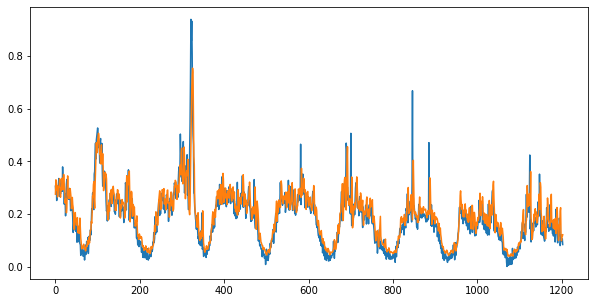

In [39]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_s)
plt.show()

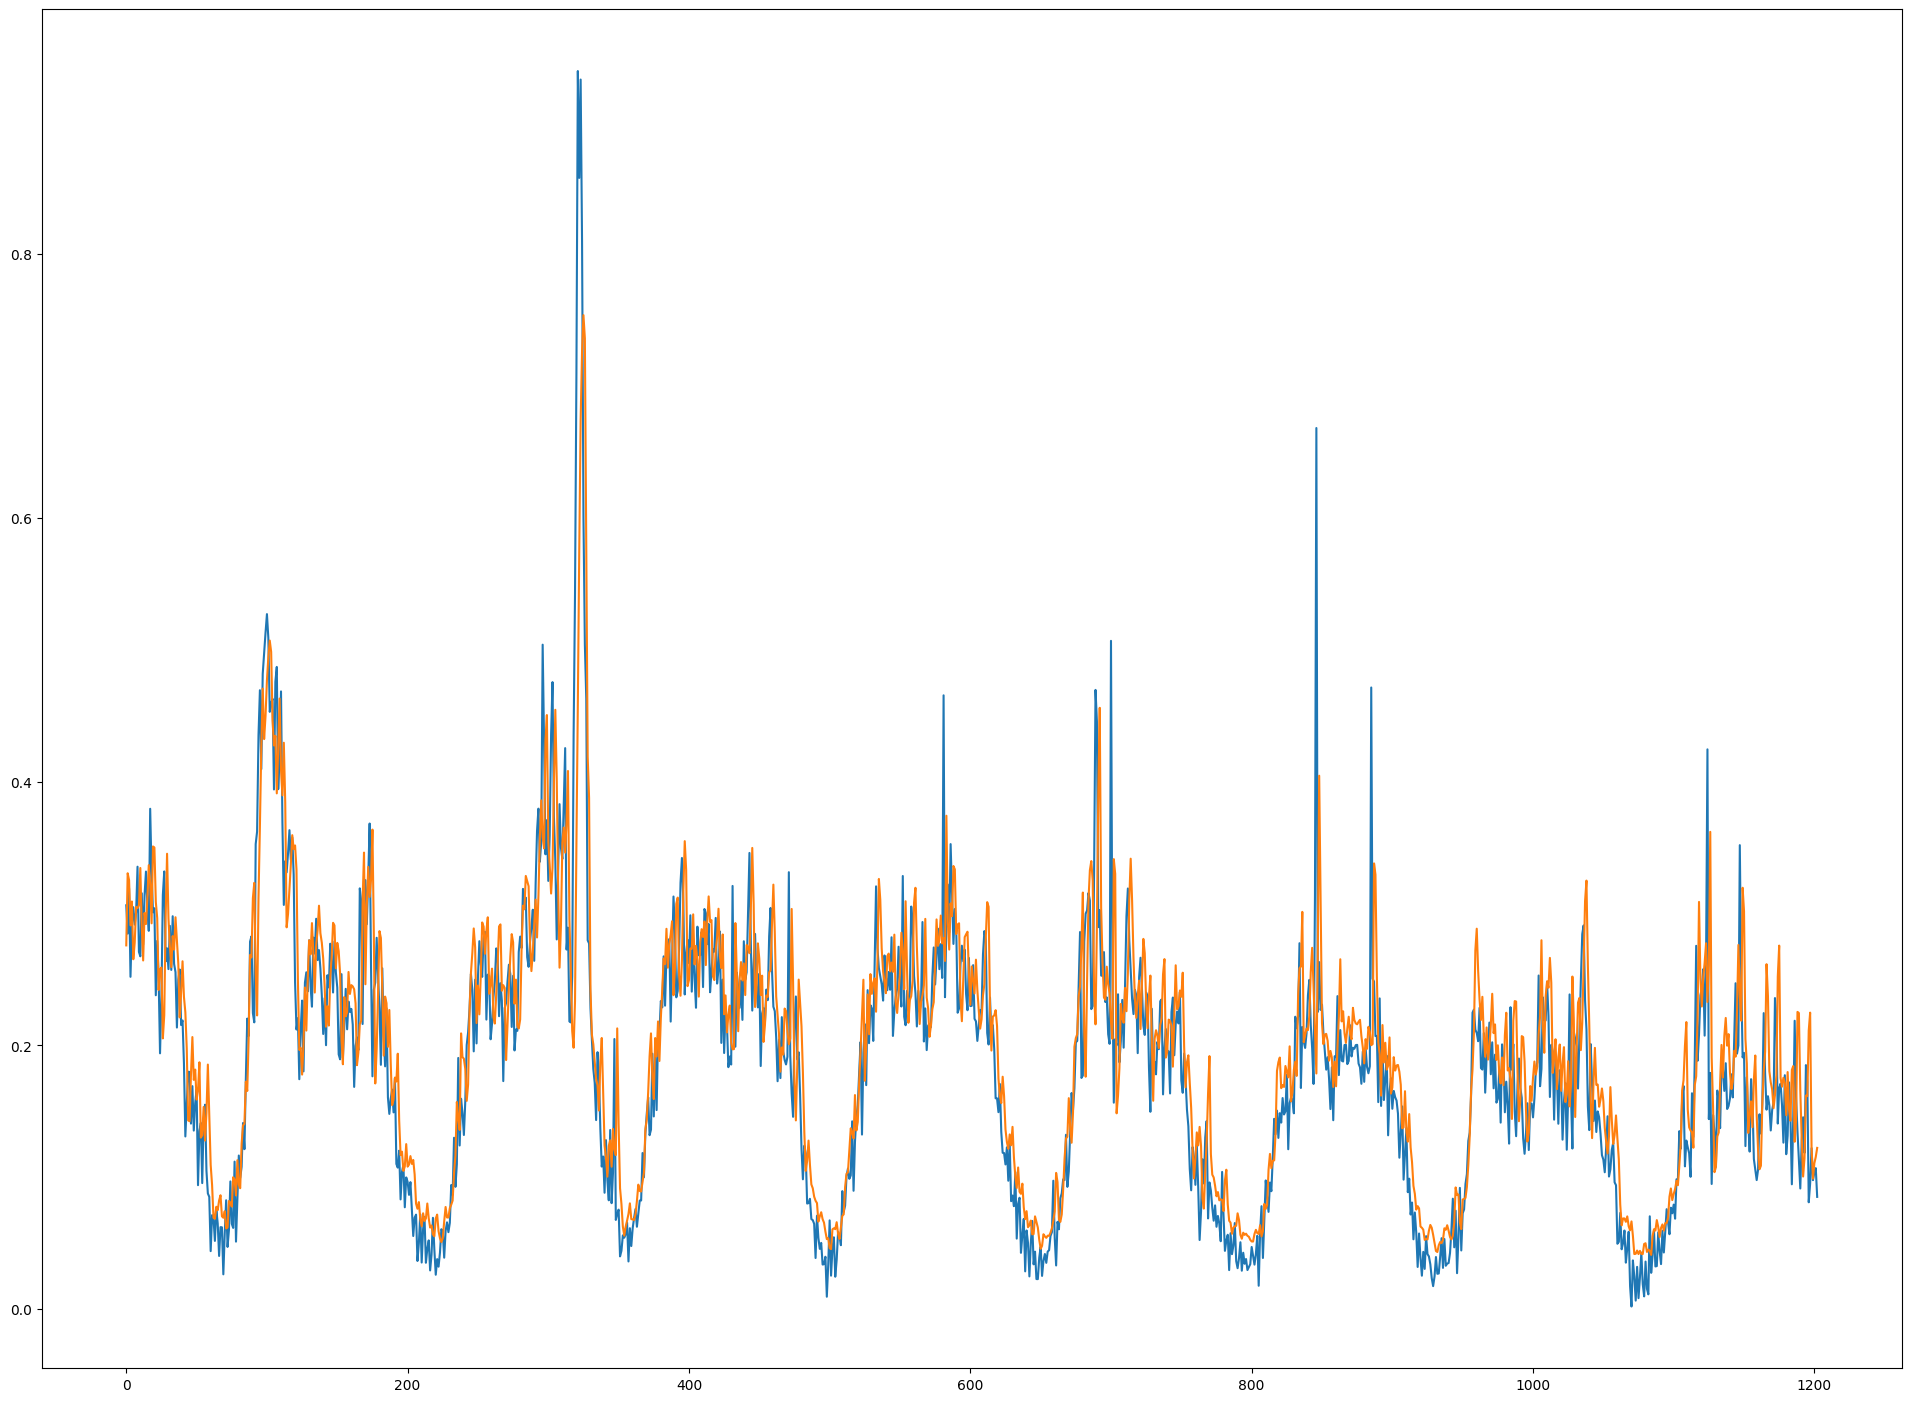

In [40]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_s)
plt.savefig('transformed_data/images/BEST-5644-6-0-1_GRU.png',bbox_inches='tight')
plt.show()

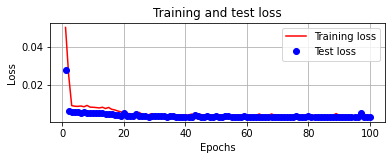

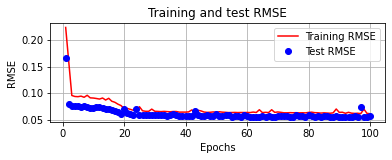

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_gru_s.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_gru_s.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_gru_s.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5644-6-0-1_GRU_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [42]:
print (dmse)

0.021220407


In [43]:
print (drmse)

0.05622471


# Conjunto LSTM y GRU

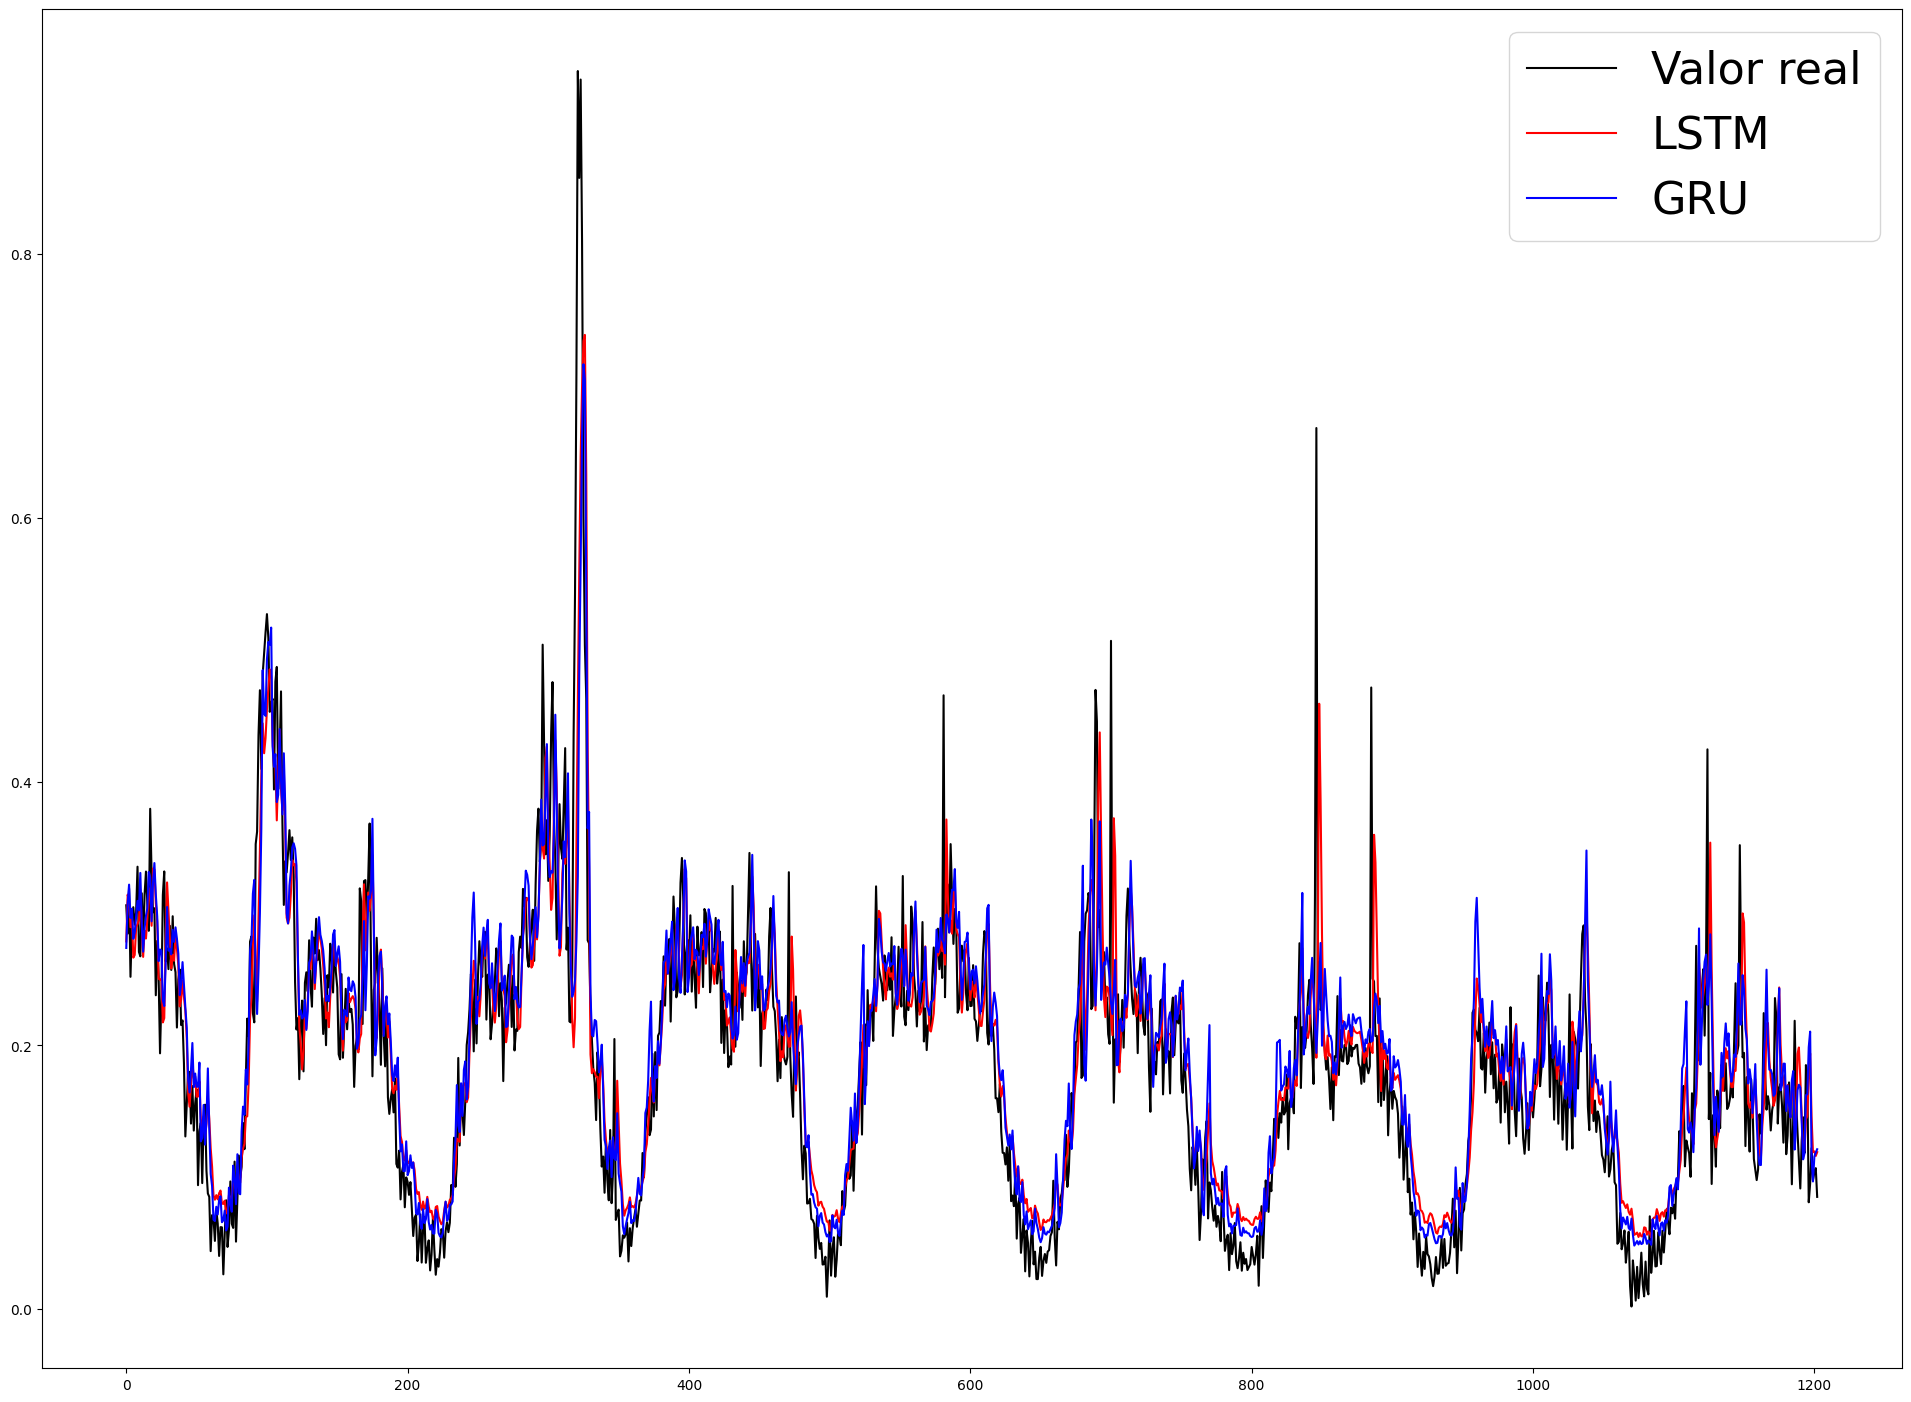

In [165]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
glstm, = plt.plot(test_predictions_lstm_s, color='r')
ggru, = plt.plot(test_predictions_gru_s, color='b')

plt.legend([real, glstm, ggru], ["Valor real", "LSTM", "GRU"], prop={'size': 32})

plt.savefig('transformed_data/images/5644-6-0-1_LSTM_GRU_COMB.png',bbox_inches='tight')
plt.show()

# Recurrent neural network con cambio de variables con la CellId 5644 multivariate time series

In [45]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [46]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
multi_data5644.head()

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
2166.0    -0.200000              99.0            0.0   0.366667  135.029209
2167.0    -0.283333              99.0            0.0   0.405556  107.493371
2168.0    -0.366667              99.0            0.0   0.444444  116.361533
2169.0    -0.450000              99.0            0.0   0.483333  127.892932
2170.0    -0.533333              99.0            0.0   0.522222  110.755299

In [47]:
len(multi_data5644)

4033

In [48]:
dataset = multi_data5644.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

<Figure size 2400x1800 with 0 Axes>

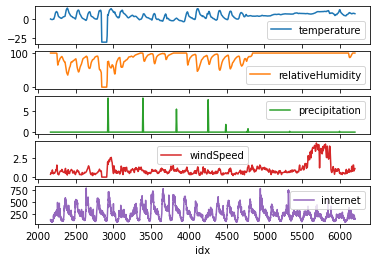

In [49]:
plt.figure(figsize=(24, 18), dpi=100) 
multi_data5644.plot(subplots=True)
plt.savefig('transformed_data/images/Prueba1.png',bbox_inches='tight')
plt.show()

In [50]:
multi_data5644

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
2166.0    -0.200000              99.0            0.0   0.366667  135.029209
2167.0    -0.283333              99.0            0.0   0.405556  107.493371
2168.0    -0.366667              99.0            0.0   0.444444  116.361533
2169.0    -0.450000              99.0            0.0   0.483333  127.892932
2170.0    -0.533333              99.0            0.0   0.522222  110.755299
...             ...               ...            ...        ...         ...
6194.0     6.733333              99.0            0.0   1.100000  170.734492
6195.0     6.700000              99.0            0.0   1.100000  153.487745
6196.0     6.666667              99.0            0.0   1.100000  157.522089
6197.0     6.633333              99.0            0.0   1.100000  159.975281
6198.0     6.600000              99.0            0.0   1.100000  144.458604

[4033 rows x 5 columns]

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [52]:
dataset = DataScaledMeteoCellId5644

In [53]:
dataset

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [54]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [55]:
dataset[:, 4]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [56]:
dataset

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [57]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [58]:
x_train_multi[0]

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       [0.67391304, 1.        , 0.        , 0.10902256, 0.0618963 ],
       [0.6720061 , 1.        , 0.        , 0.11779449, 0.03779875],
       [0.67009916, 1.        , 0.        , 0.12656642, 0.04907265]])

In [59]:
y_train_multi[0]

0.03359665147127812

In [60]:
EPOCHS = [50]
BATCH_SIZE = [64]
NODOS = [32]
LAYERS = [4]
LEARNINGRATE = [0.001]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_lstm_m = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm_m.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm_m.add(tf.keras.layers.LSTM(nodo))
                simple_lstm_m.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm_m.summary()

                simple_lstm_m.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_lstm_m = simple_lstm_m.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_lstm_m.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_lstm_m = simple_lstm_m.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_lstm_m).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_lstm_m).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 50batch: 64nodos: 32layer: 4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 6, 32)             4352      
_________________________________________________________________
lstm_5 (LSTM)                (None, 6, 32)             8320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 6, 32)             8320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
45/45 [==============================] - 2s 47ms/step - loss: 0.0518

In [61]:
test_predictions_lstm_m

array([[0.3071584 ],
       [0.33756328],
       [0.33545452],
       ...,
       [0.13001335],
       [0.12620702],
       [0.13260195]], dtype=float32)

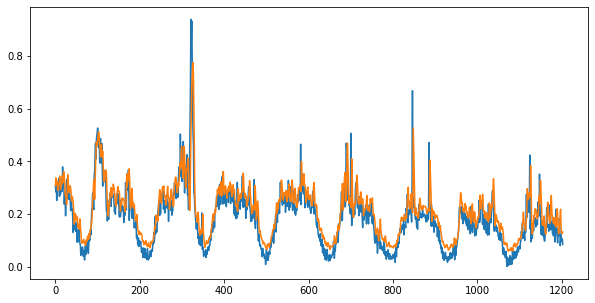

In [62]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_m)
plt.show()

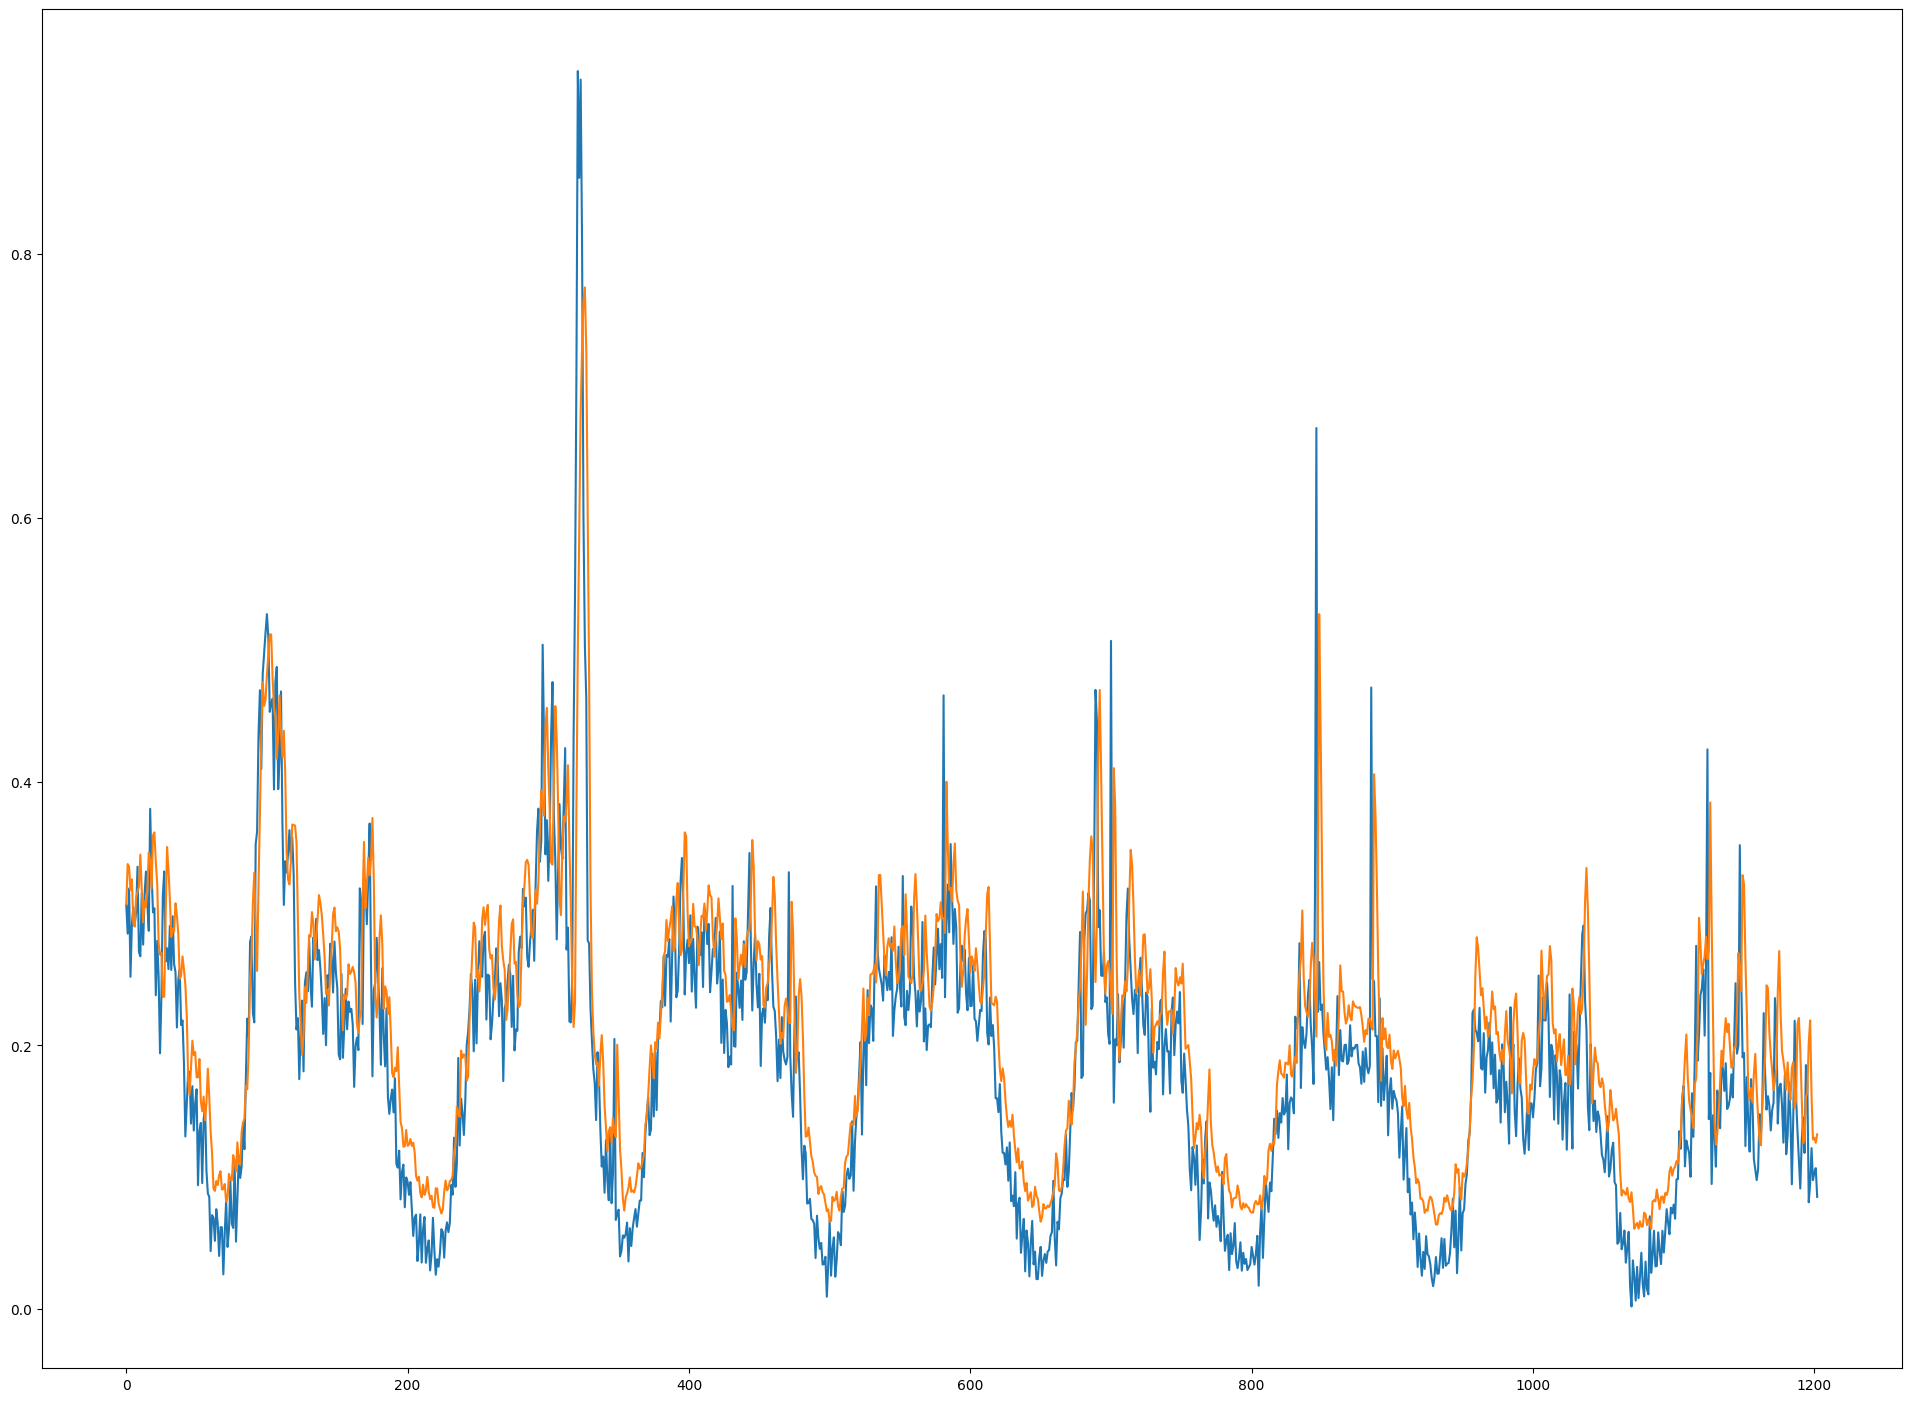

In [63]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_m)
plt.savefig('transformed_data/images/BEST-5644-6-0-1-TRPW-LSTM.png',bbox_inches='tight')
plt.show()

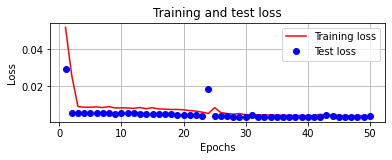

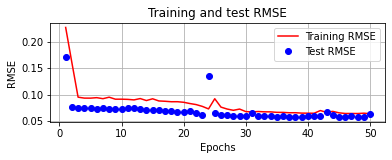

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_lstm_m.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_lstm_m.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_lstm_m.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5644-6-0-1-TRPW-LSTM_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [65]:
print (dmse)

0.022042694


In [66]:
print (drmse)

0.062906966


# Recurrent neural network con cambio de hiperparametros con la CellId 5644 multivariate time series - GRU

In [67]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [68]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
multi_data5644.head()

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
2166.0    -0.200000              99.0            0.0   0.366667  135.029209
2167.0    -0.283333              99.0            0.0   0.405556  107.493371
2168.0    -0.366667              99.0            0.0   0.444444  116.361533
2169.0    -0.450000              99.0            0.0   0.483333  127.892932
2170.0    -0.533333              99.0            0.0   0.522222  110.755299

In [69]:
len(multi_data5644)

4033

In [70]:
multi_data5644

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
2166.0    -0.200000              99.0            0.0   0.366667  135.029209
2167.0    -0.283333              99.0            0.0   0.405556  107.493371
2168.0    -0.366667              99.0            0.0   0.444444  116.361533
2169.0    -0.450000              99.0            0.0   0.483333  127.892932
2170.0    -0.533333              99.0            0.0   0.522222  110.755299
...             ...               ...            ...        ...         ...
6194.0     6.733333              99.0            0.0   1.100000  170.734492
6195.0     6.700000              99.0            0.0   1.100000  153.487745
6196.0     6.666667              99.0            0.0   1.100000  157.522089
6197.0     6.633333              99.0            0.0   1.100000  159.975281
6198.0     6.600000              99.0            0.0   1.100000  144.458604

[4033 rows x 5 columns]

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [72]:
dataset = DataScaledMeteoCellId5644

In [73]:
dataset

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [74]:
len(dataset)

4033

In [75]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [76]:
dataset[:, 4]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [77]:
dataset #dataset[:, [0,1,2,3]]

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [78]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [79]:
len(x_train_multi)

2817

In [80]:
len(x_val_multi)

1203

In [81]:
EPOCHS = [75]
BATCH_SIZE = [256] #128
NODOS = [32] #64
LAYERS = [8]
LEARNINGRATE = [0.001]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_gru_m = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_gru_m.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_gru_m.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_gru_m.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_gru_m.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_gru_m.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_gru_m.add(tf.keras.layers.GRU(nodo))
                simple_gru_m.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_gru_m.summary()

                simple_gru_m.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_gru_m = simple_gru_m.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_gru_m.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_gru_m = simple_gru_m.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_gru_m).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_gru_m).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 75batch: 256nodos: 32layer: 8
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 6, 32)             3360      
_________________________________________________________________
gru_9 (GRU)                  (None, 6, 32)             6336      
_________________________________________________________________
gru_10 (GRU)                 (None, 6, 32)             6336      
_________________________________________________________________
gru_11 (GRU)                 (None, 6, 32)             6336      
_________________________________________________________________
gru_12 (GRU)                 (None, 6, 32)             6336      
_________________________________________________________________
gru_13 (GRU)                 (None, 6, 32)             6336      
_________________________________________________________________
gru_14 (GRU)    

In [82]:
test_predictions_gru_m

array([[0.29247707],
       [0.3104766 ],
       [0.3197515 ],
       ...,
       [0.10907429],
       [0.10854563],
       [0.10907128]], dtype=float32)

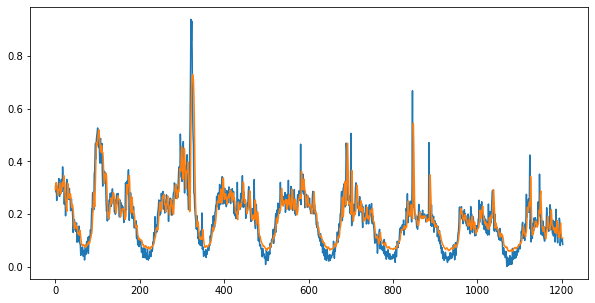

In [83]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_m)
plt.show()

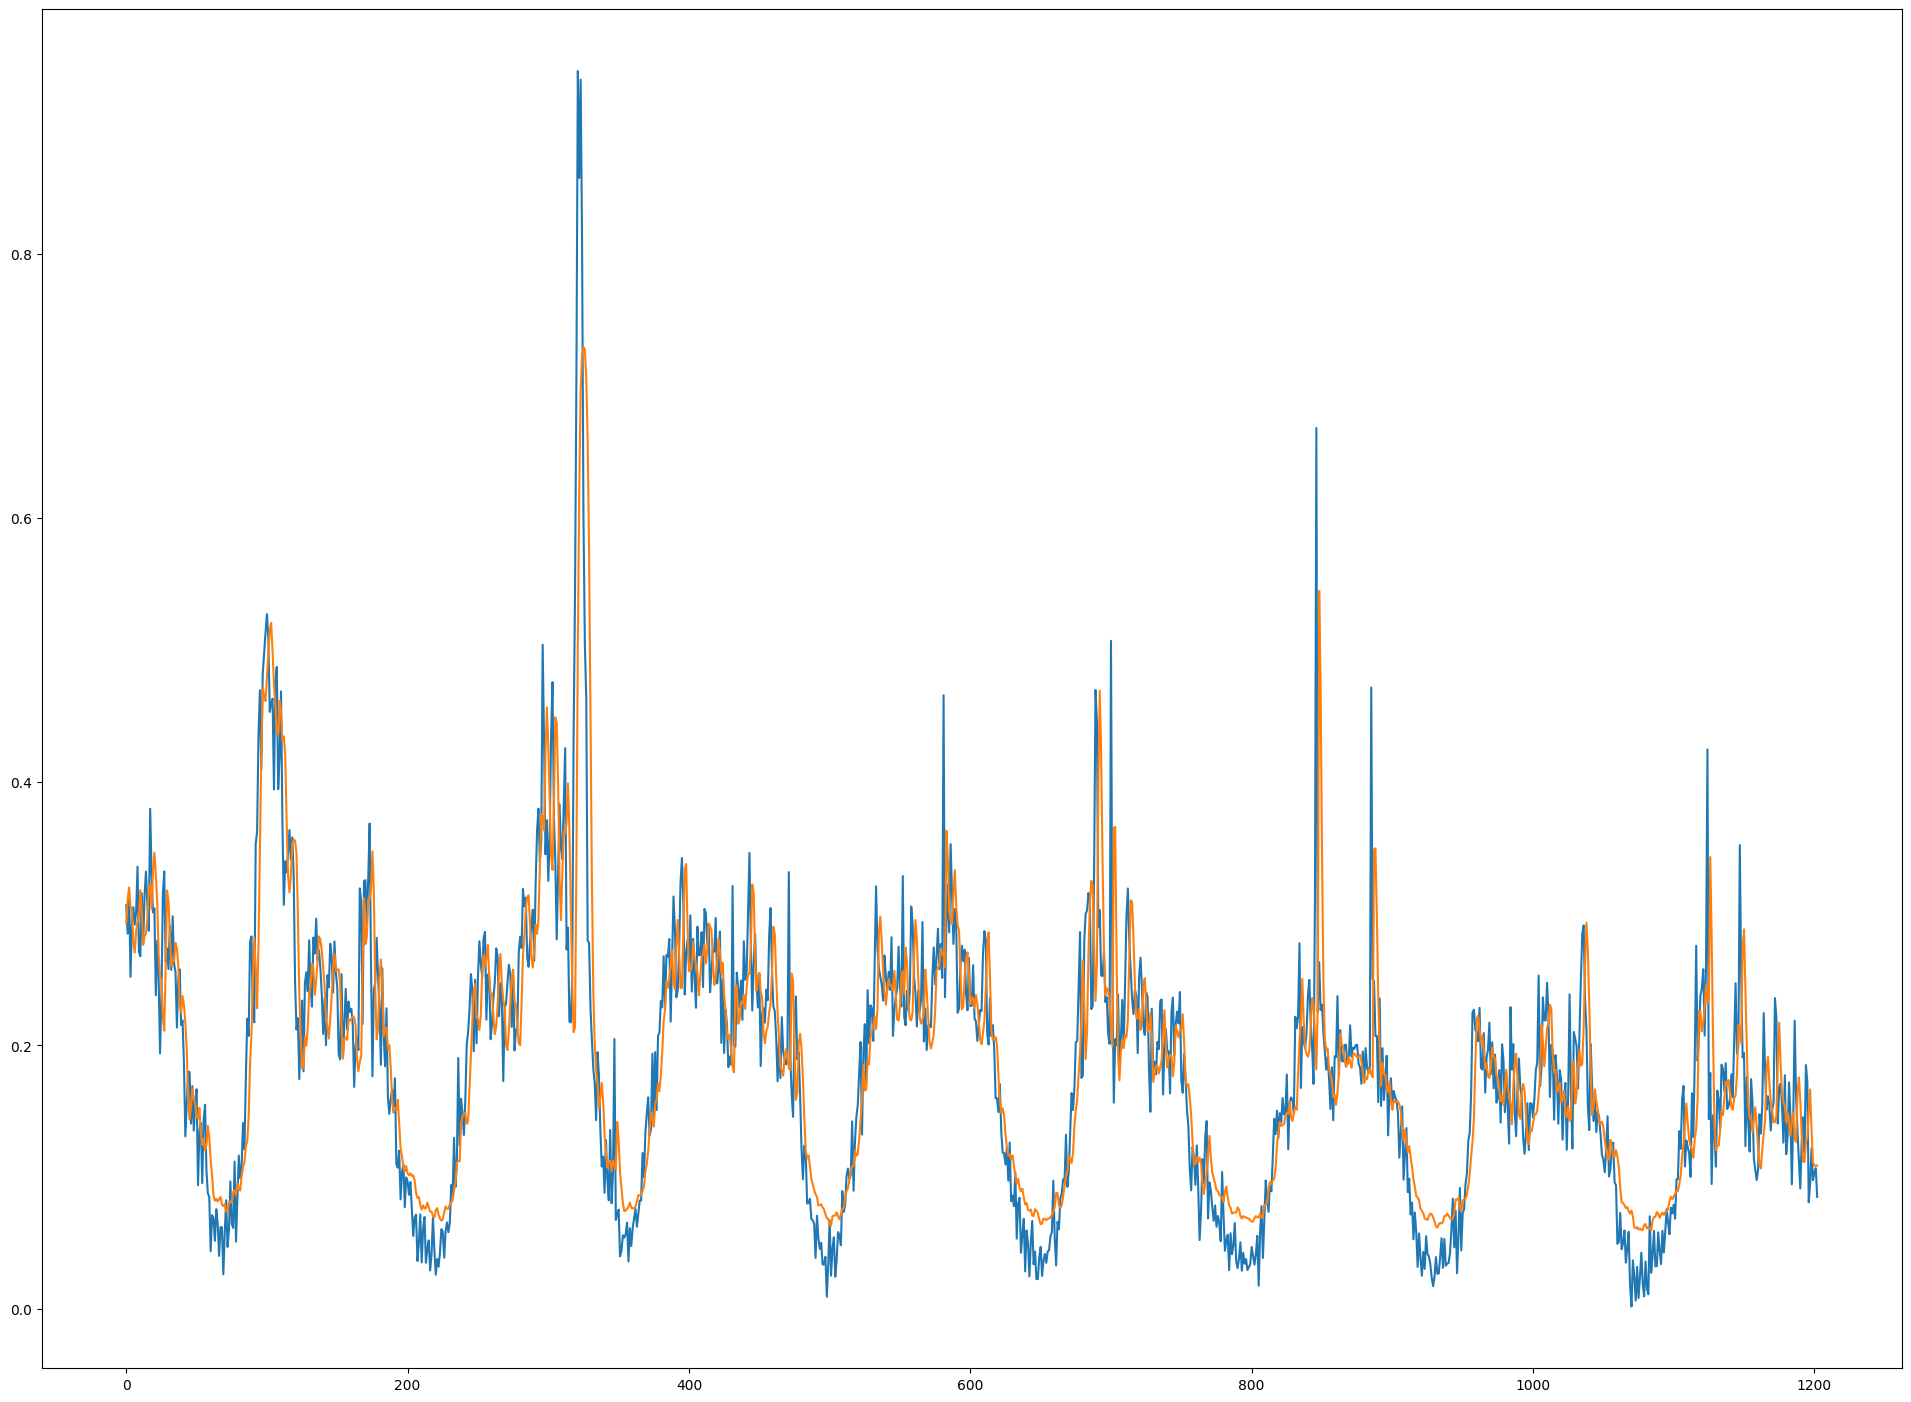

In [84]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_m)
plt.savefig('transformed_data/images/BEST-5644-6-0-1-TRPW-GRU.png',bbox_inches='tight')
plt.show()

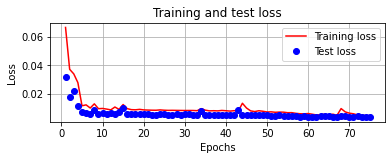

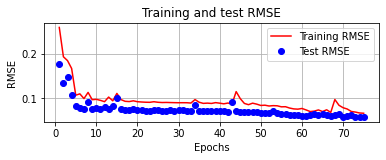

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_gru_m.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_gru_m.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_gru_m.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5644-6-0-1-TRPW-GRU_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [86]:
print (dmse)

0.021187345


In [87]:
print (drmse)

0.05766222


# Conjunto LSTM y GRU

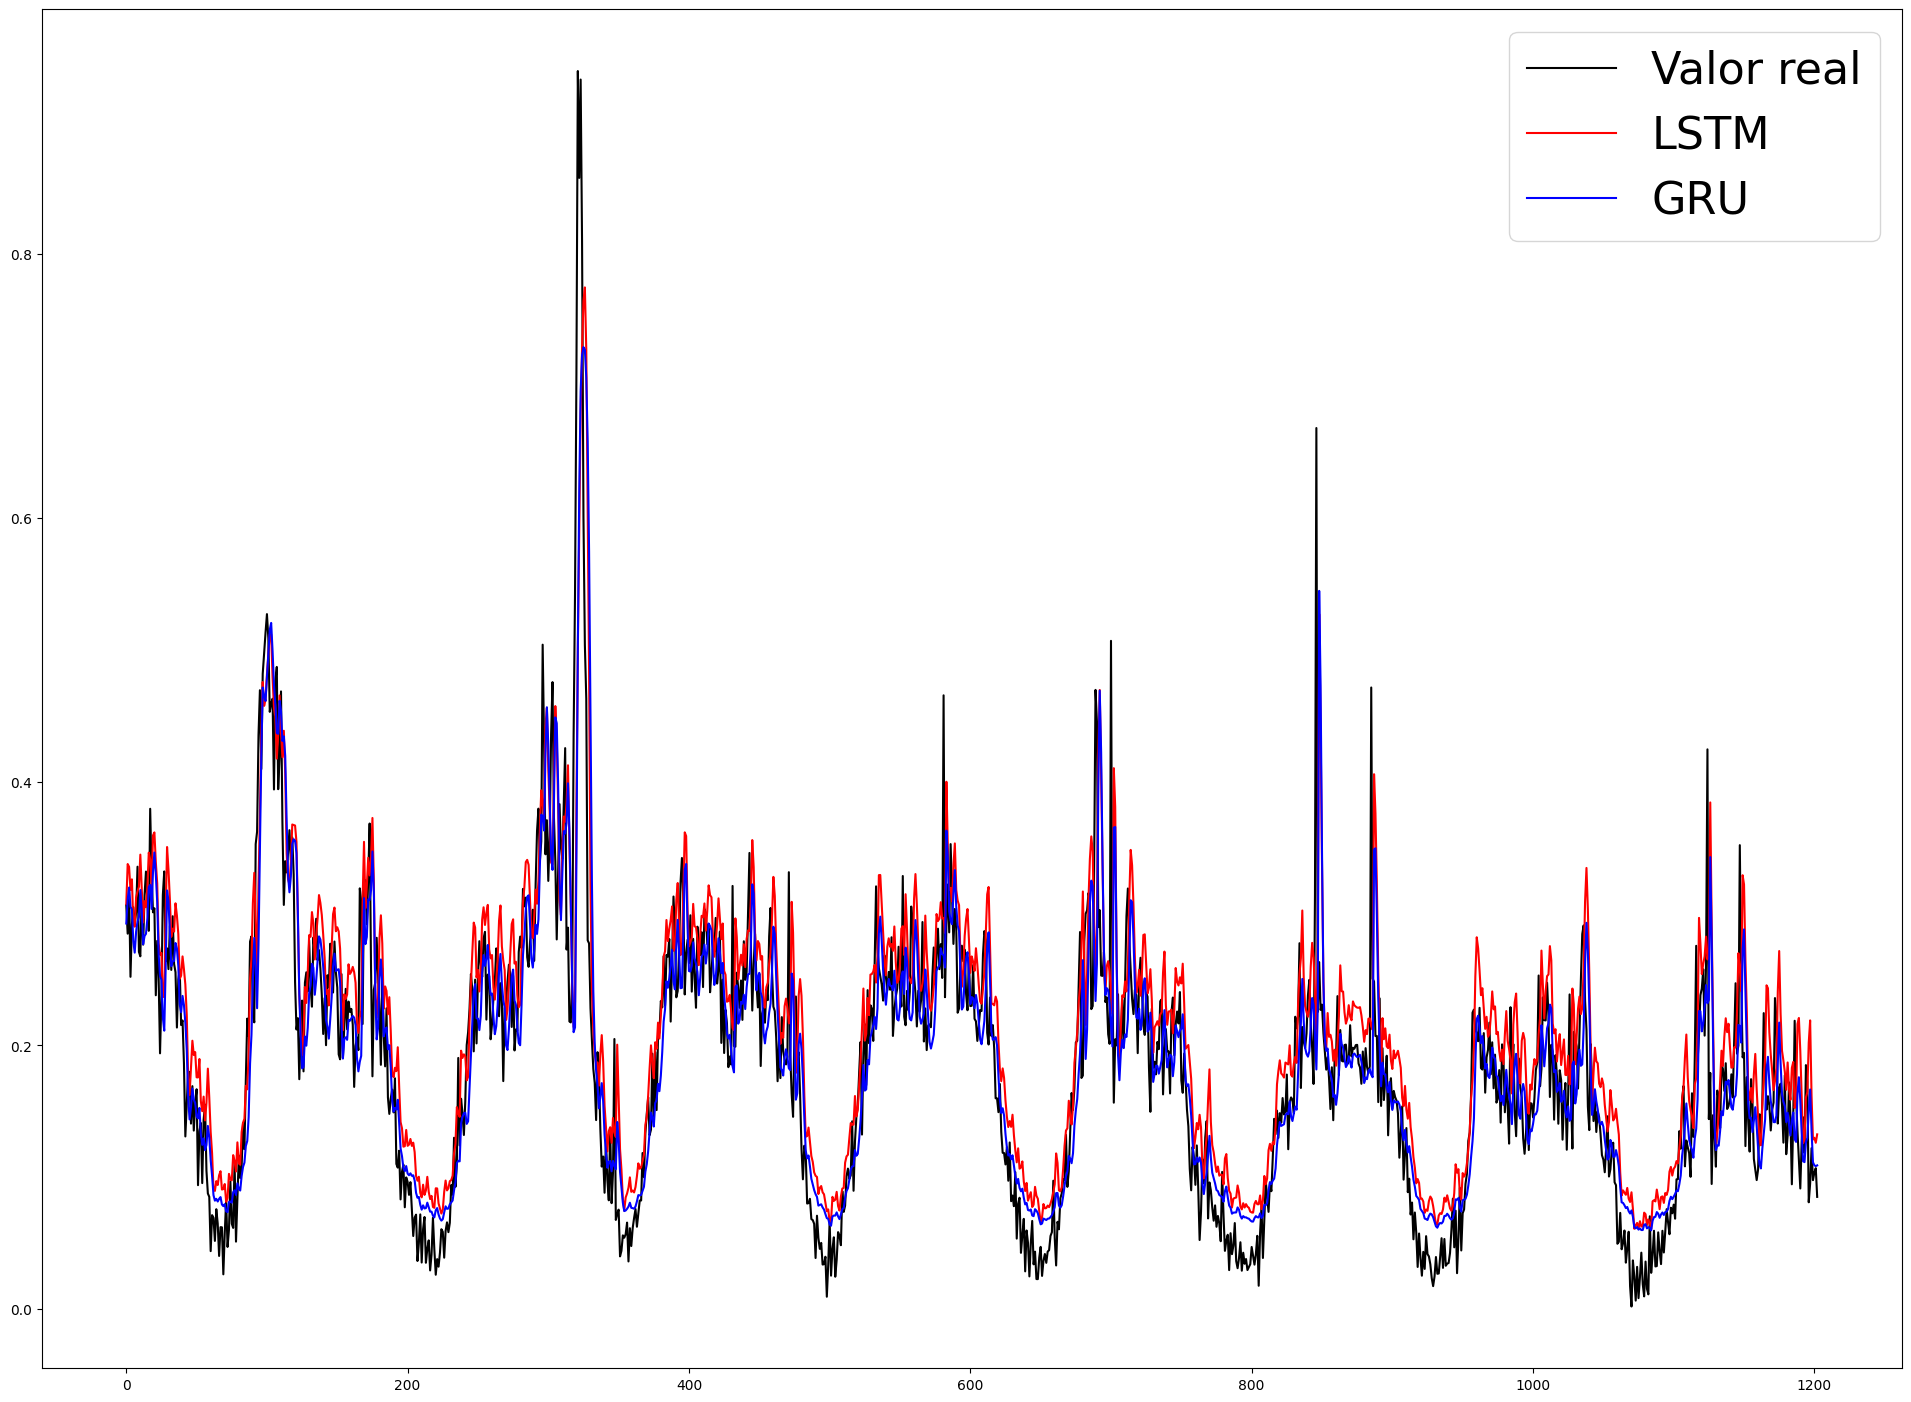

In [88]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
glstm, = plt.plot(test_predictions_lstm_m, color='r')
ggru, = plt.plot(test_predictions_gru_m, color='b')

plt.legend([real, glstm, ggru], ["Valor real", "LSTM", "GRU"], prop={'size': 32})

plt.savefig('transformed_data/images/5644-6-0-1-TRPW_LSTM_GRU_COMB.png',bbox_inches='tight')
plt.show()

# Recurrent neural network con cambio de variables con la CellId 5644 multivariate time series SEPARADO

In [89]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet'] #		temperature	windSpeed

In [90]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
multi_data5644.head()

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
2166.0    -0.200000              99.0            0.0   0.366667  135.029209
2167.0    -0.283333              99.0            0.0   0.405556  107.493371
2168.0    -0.366667              99.0            0.0   0.444444  116.361533
2169.0    -0.450000              99.0            0.0   0.483333  127.892932
2170.0    -0.533333              99.0            0.0   0.522222  110.755299

In [91]:
len(multi_data5644)

4033

In [92]:
dataset = multi_data5644.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [93]:
multi_data5644

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
2166.0    -0.200000              99.0            0.0   0.366667  135.029209
2167.0    -0.283333              99.0            0.0   0.405556  107.493371
2168.0    -0.366667              99.0            0.0   0.444444  116.361533
2169.0    -0.450000              99.0            0.0   0.483333  127.892932
2170.0    -0.533333              99.0            0.0   0.522222  110.755299
...             ...               ...            ...        ...         ...
6194.0     6.733333              99.0            0.0   1.100000  170.734492
6195.0     6.700000              99.0            0.0   1.100000  153.487745
6196.0     6.666667              99.0            0.0   1.100000  157.522089
6197.0     6.633333              99.0            0.0   1.100000  159.975281
6198.0     6.600000              99.0            0.0   1.100000  144.458604

[4033 rows x 5 columns]

In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [95]:
dataset = DataScaledMeteoCellId5644

In [96]:
dataset

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [97]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [98]:
dataset[:, 4]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [99]:
dataset[:, [0,1,2,3]]

array([[0.67963387, 1.        , 0.        , 0.08270677],
       [0.67772693, 1.        , 0.        , 0.0914787 ],
       [0.67581998, 1.        , 0.        , 0.10025063],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 ],
       [0.83600305, 1.        , 0.        , 0.2481203 ],
       [0.83524027, 1.        , 0.        , 0.2481203 ]])

In [100]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [101]:
x_train_multi[0]

array([[0.67963387, 1.        , 0.        , 0.08270677],
       [0.67772693, 1.        , 0.        , 0.0914787 ],
       [0.67581998, 1.        , 0.        , 0.10025063],
       [0.67391304, 1.        , 0.        , 0.10902256],
       [0.6720061 , 1.        , 0.        , 0.11779449],
       [0.67009916, 1.        , 0.        , 0.12656642]])

In [102]:
y_train_multi[0]

0.03359665147127812

In [103]:
EPOCHS = [50]
BATCH_SIZE = [64]
NODOS = [32]
LAYERS = [4]
LEARNINGRATE = [0.002]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_lstm_m_s = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo))
                else :
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo, return_sequences=True))
                    simple_lstm_m_s.add(tf.keras.layers.LSTM(nodo))
                simple_lstm_m_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_lstm_m_s.summary()

                simple_lstm_m_s.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_lstm_m_s = simple_lstm_m_s.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=1)
                
                score = simple_lstm_m_s.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_lstm_m_s = simple_lstm_m_s.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_lstm_m_s).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_lstm_m_s).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 50batch: 64nodos: 32layer: 4
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 6, 32)             4352      
_________________________________________________________________
lstm_9 (LSTM)                (None, 6, 32)             8320      
_________________________________________________________________
lstm_10 (LSTM)               (None, 6, 32)             8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
45/45 [==============================] - 3s 67ms/step - loss: 0.0426

In [104]:
test_predictions_lstm_m_s

array([[0.2940358 ],
       [0.32987452],
       [0.32797378],
       ...,
       [0.12419167],
       [0.12444019],
       [0.1303111 ]], dtype=float32)

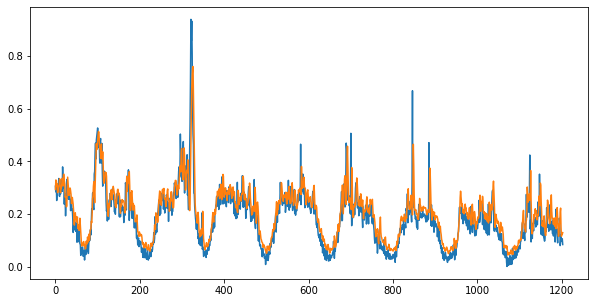

In [105]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_m_s)
plt.show()

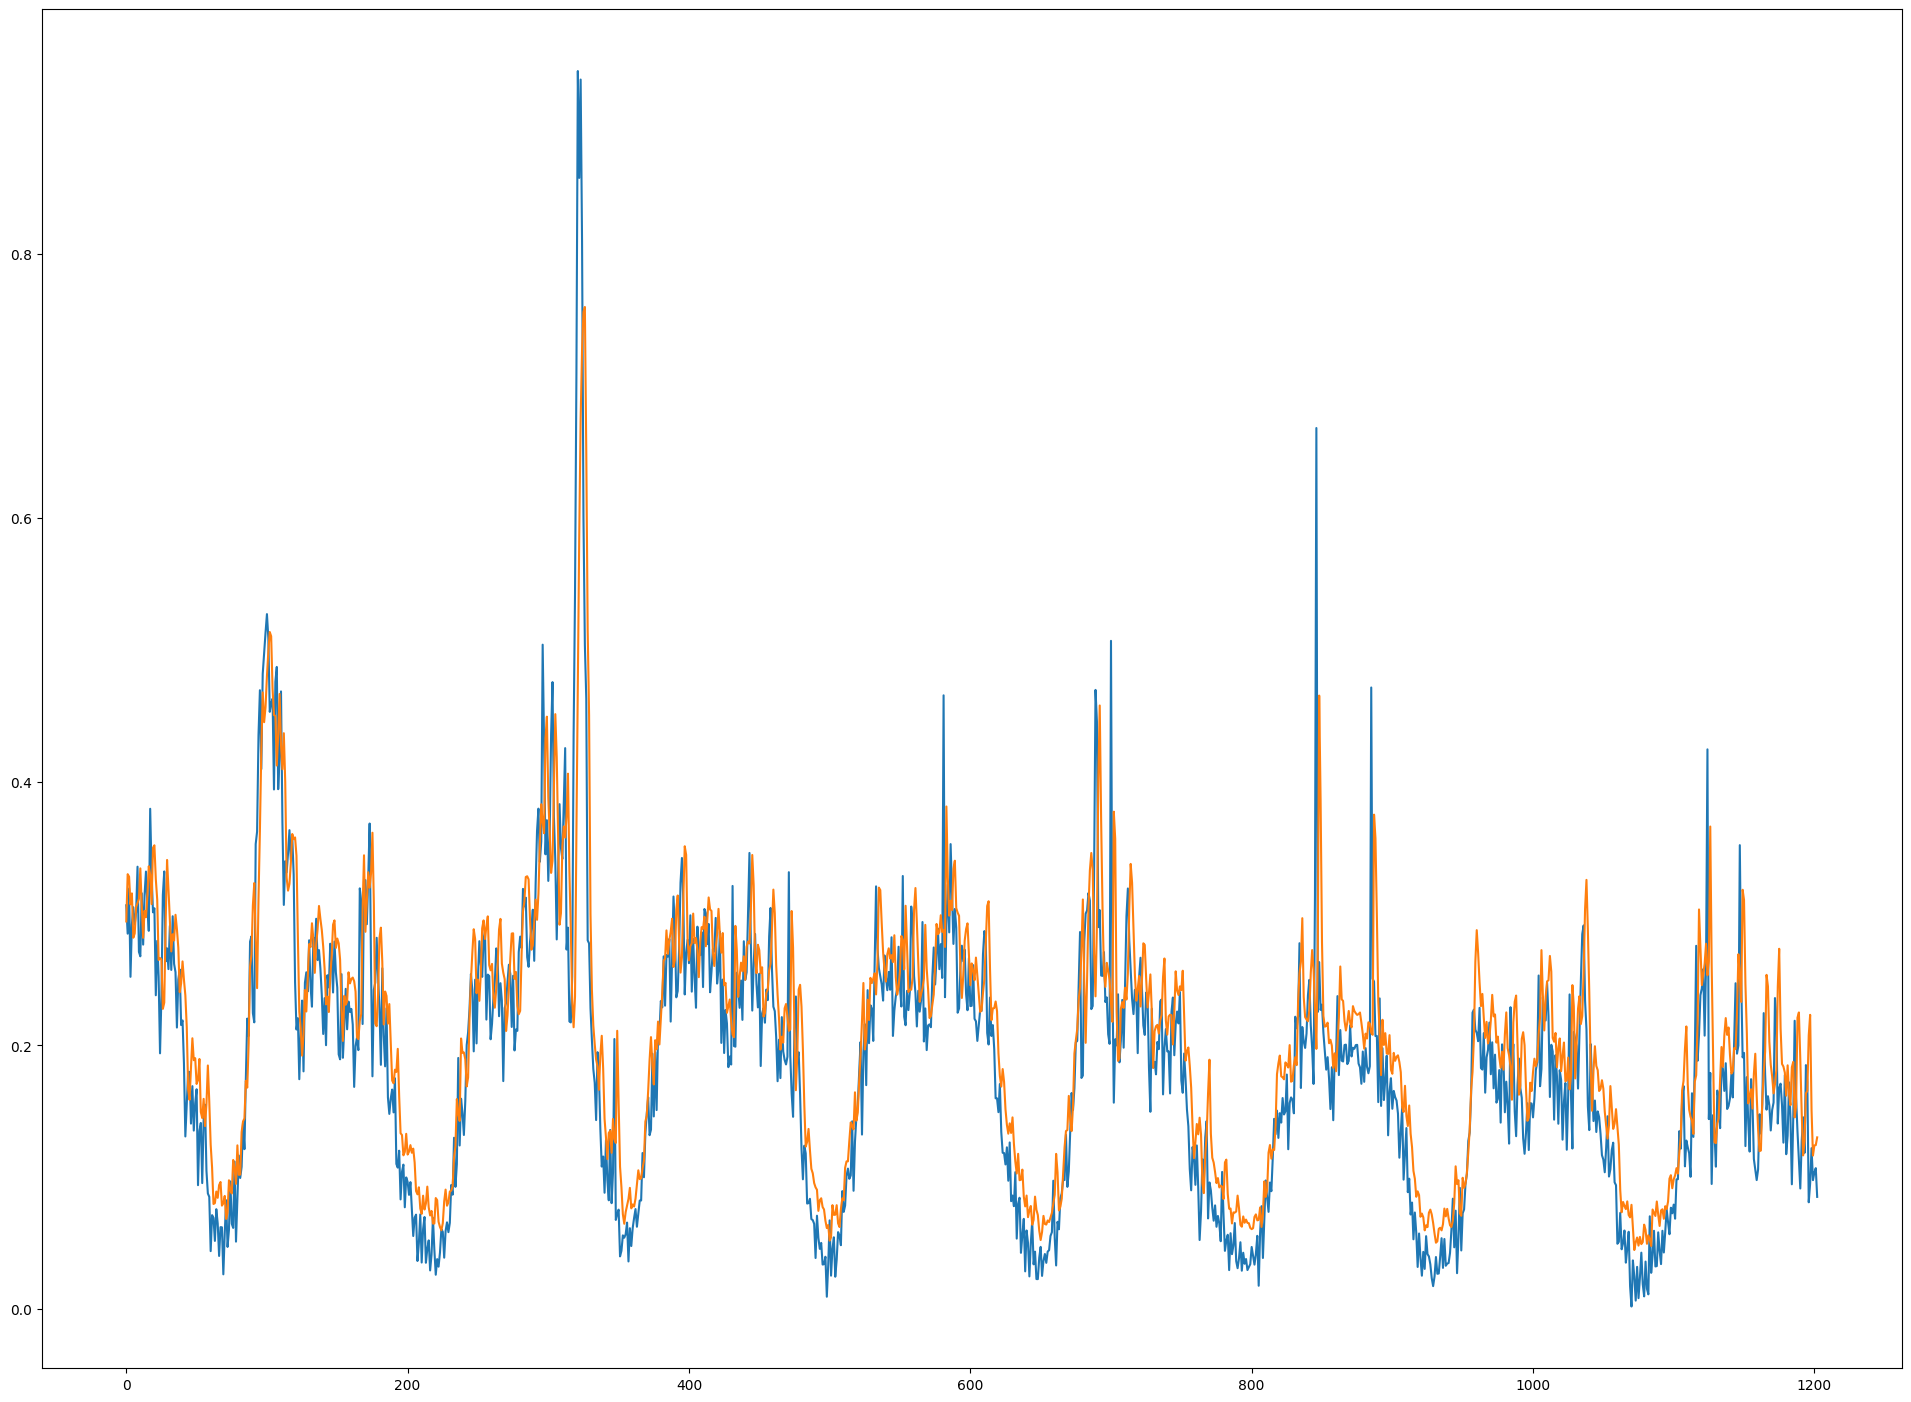

In [106]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_lstm_m_s)
plt.savefig('transformed_data/images/BEST-5644-6-0-1-TRPW-sep-LSTM.png',bbox_inches='tight')
plt.show()

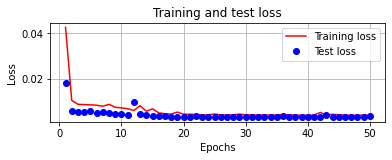

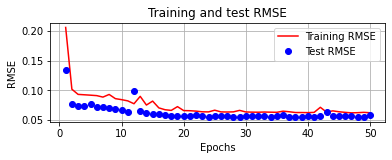

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_lstm_m_s.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_lstm_m_s.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_lstm_m_s.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5644-6-0-1-TRPW-sep-LSTM_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [108]:
print (dmse)

0.021460198


In [109]:
print (drmse)

0.058728162


# Recurrent neural network con cambio de hiperparametros con la CellId 5644 multivariate time series - GRU SEPARADO

In [110]:
features_considered = ['temperature', 'relativeHumidity', 'precipitation', 'windSpeed', 'internet']

In [111]:
multi_data5644 = dataMeteoCellId5644[features_considered]
multi_data5644.index = dataMeteoCellId5644['idx'] - 47088.0
multi_data5644.head()

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
2166.0    -0.200000              99.0            0.0   0.366667  135.029209
2167.0    -0.283333              99.0            0.0   0.405556  107.493371
2168.0    -0.366667              99.0            0.0   0.444444  116.361533
2169.0    -0.450000              99.0            0.0   0.483333  127.892932
2170.0    -0.533333              99.0            0.0   0.522222  110.755299

In [112]:
len(multi_data5644)

4033

In [113]:
multi_data5644

temperature  relativeHumidity  precipitation  windSpeed    internet
idx                                                                        
2166.0    -0.200000              99.0            0.0   0.366667  135.029209
2167.0    -0.283333              99.0            0.0   0.405556  107.493371
2168.0    -0.366667              99.0            0.0   0.444444  116.361533
2169.0    -0.450000              99.0            0.0   0.483333  127.892932
2170.0    -0.533333              99.0            0.0   0.522222  110.755299
...             ...               ...            ...        ...         ...
6194.0     6.733333              99.0            0.0   1.100000  170.734492
6195.0     6.700000              99.0            0.0   1.100000  153.487745
6196.0     6.666667              99.0            0.0   1.100000  157.522089
6197.0     6.633333              99.0            0.0   1.100000  159.975281
6198.0     6.600000              99.0            0.0   1.100000  144.458604

[4033 rows x 5 columns]

In [114]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
DataScaledMeteoCellId5644 = scaler.fit_transform(multi_data5644)

In [115]:
dataset = DataScaledMeteoCellId5644

In [116]:
dataset

array([[0.67963387, 1.        , 0.        , 0.08270677, 0.07193076],
       [0.67772693, 1.        , 0.        , 0.0914787 , 0.03321209],
       [0.67581998, 1.        , 0.        , 0.10025063, 0.04568178],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 , 0.10355843],
       [0.83600305, 1.        , 0.        , 0.2481203 , 0.10700791],
       [0.83524027, 1.        , 0.        , 0.2481203 , 0.08518961]])

In [117]:
len(dataset)

4033

In [118]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
              labels.append(target[i+target_size])
        else:
              labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [119]:
dataset[:, 4]

array([0.07193076, 0.03321209, 0.04568178, ..., 0.10355843, 0.10700791,
       0.08518961])

In [120]:
dataset[:, [0,1,2,3]]

array([[0.67963387, 1.        , 0.        , 0.08270677],
       [0.67772693, 1.        , 0.        , 0.0914787 ],
       [0.67581998, 1.        , 0.        , 0.10025063],
       ...,
       [0.83676583, 1.        , 0.        , 0.2481203 ],
       [0.83600305, 1.        , 0.        , 0.2481203 ],
       [0.83524027, 1.        , 0.        , 0.2481203 ]])

In [121]:
#univariate_past_history = 6
#univariate_future_target = 1
past_history = 6
future_target = 1
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(dataset[:, [0,1,2,3]], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [122]:
len(x_train_multi)

2817

In [123]:
len(x_val_multi)

1203

In [124]:
EPOCHS = [75]
BATCH_SIZE = [256]
NODOS = [64]
LAYERS = [8]
LEARNINGRATE = [0.0005]

i = 1
model5644ArrayAcc = []
model5644mse = []
for epoch in EPOCHS:
    for batch in BATCH_SIZE:
        for nodo in NODOS:
            for layer in LAYERS:
                msg = "epochs: " + str(epoch) + "batch: " + str(batch) + "nodos: " + str(nodo) + "layer: " + str(layer)
                print (msg)
                adam= tf.keras.optimizers.Adam(lr=LEARNINGRATE[0])
                simple_gru_m_s = tf.keras.models.Sequential()
                if layer == 1 :
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:]))
                elif layer == 2 :
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo))
                else :
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo, input_shape=x_train_uni.shape[-2:], return_sequences=True))        
                    for x in range (layer-2):
                        simple_gru_m_s.add(tf.keras.layers.GRU(nodo, return_sequences=True))
                    simple_gru_m_s.add(tf.keras.layers.GRU(nodo))
                simple_gru_m_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))

                simple_gru_m_s.summary()

                simple_gru_m_s.compile(optimizer=adam, loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.losses.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

                history_gru_m_s = simple_gru_m_s.fit(x_train_uni, y_train_uni, epochs=epoch,
                              batch_size=batch,
                              validation_data=(x_val_uni, y_val_uni), verbose=0)
                
                score = simple_gru_m_s.evaluate(x_train_uni, y_train_uni, verbose=0)
                model5644ArrayAcc.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], score[0], score[1]])
                
                test_predictions_gru_m_s = simple_gru_m_s.predict(x_val_uni)
                mse = tf.keras.losses.MeanSquaredError()
                dmse = mse(y_val_uni, test_predictions_gru_m_s).numpy()
                #RMSE
                rmse = tf.keras.metrics.RootMeanSquaredError()
                drmse = rmse(y_val_uni, test_predictions_gru_m_s).numpy()
                model5644mse.append ([epoch, batch, nodo, layer, LEARNINGRATE[0], dmse, drmse])
                
                if (i % 10 == 0):
                    tf.keras.backend.clear_session()
                    test = telegram_bot_sendtext(str(i) + ". " + maquina + " creado: " + msg)
                i = i + 1

epochs: 75batch: 256nodos: 64layer: 8
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 6, 64)             12864     
_________________________________________________________________
gru_17 (GRU)                 (None, 6, 64)             24960     
_________________________________________________________________
gru_18 (GRU)                 (None, 6, 64)             24960     
_________________________________________________________________
gru_19 (GRU)                 (None, 6, 64)             24960     
_________________________________________________________________
gru_20 (GRU)                 (None, 6, 64)             24960     
_________________________________________________________________
gru_21 (GRU)                 (None, 6, 64)             24960     
_________________________________________________________________
gru_22 (GRU)    

In [125]:
test_predictions_gru_m_s

array([[0.3099143 ],
       [0.30731046],
       [0.31124946],
       ...,
       [0.11498278],
       [0.10996798],
       [0.11115348]], dtype=float32)

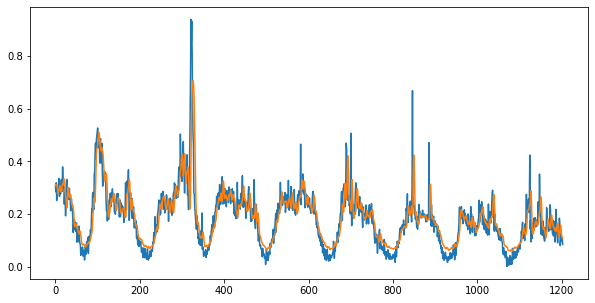

In [126]:
plt.figure(figsize=(10,5))
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_m_s)
plt.show()

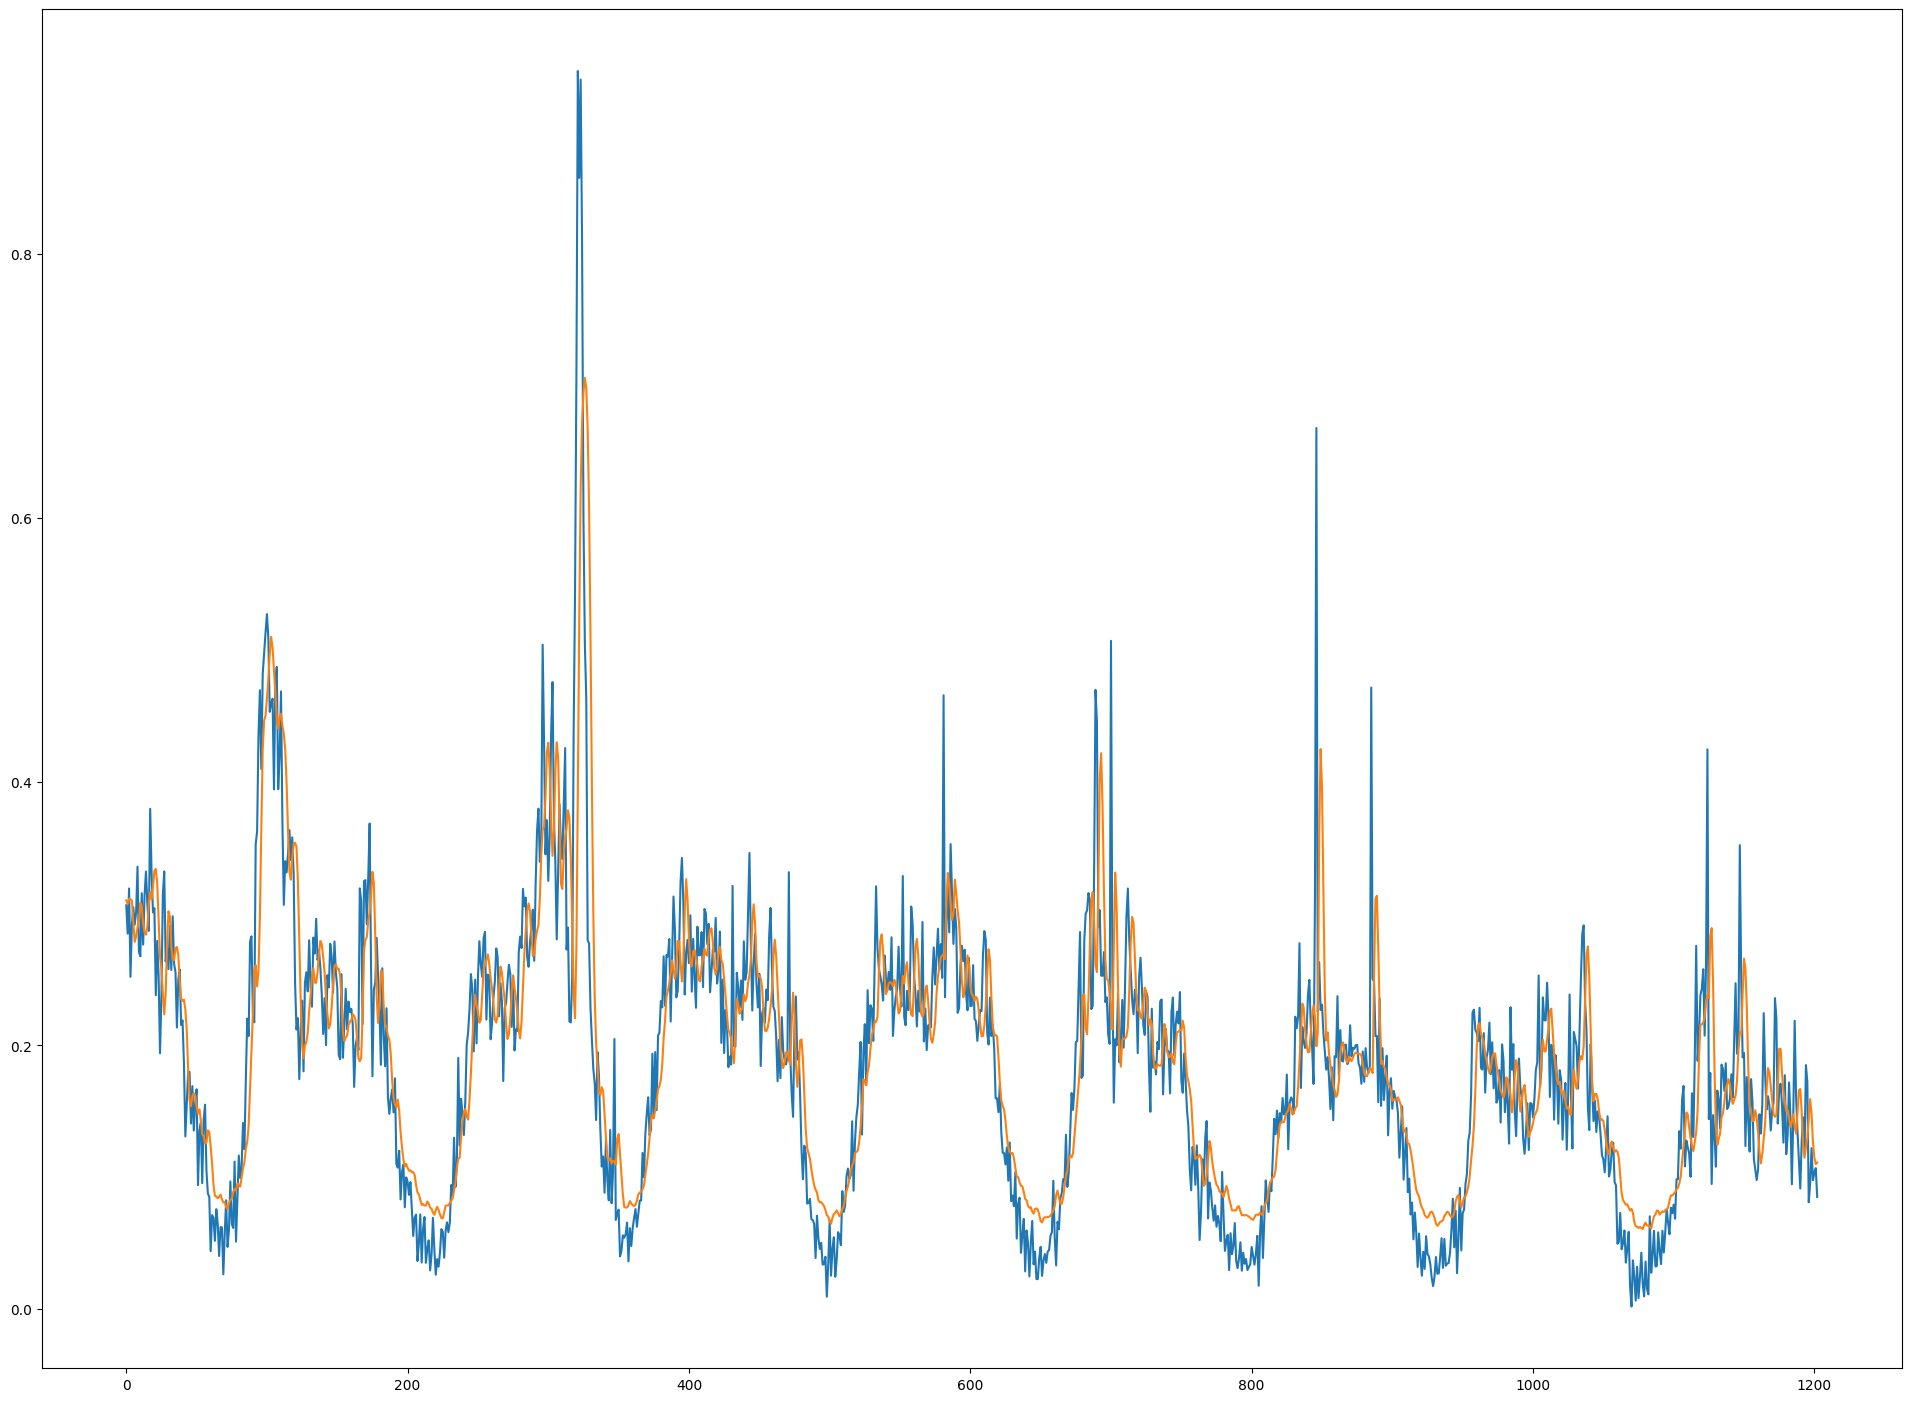

In [127]:
plt.figure(figsize=(24, 18), dpi=100) 
plt.plot(y_val_uni)
plt.plot(test_predictions_gru_m_s)
plt.savefig('transformed_data/images/BEST-5644-6-0-1-TRPW-sep-GRU.png',bbox_inches='tight')
plt.show()

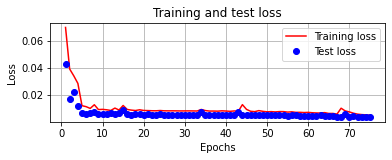

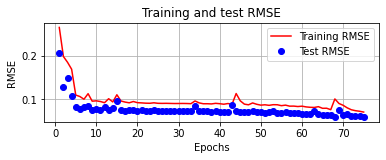

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_gru_m_s.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
rmse_values = history_dict['root_mean_squared_error']
val_rmse_values = history_dict['val_root_mean_squared_error']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_gru_m_s.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_gru_m_s.history['root_mean_squared_error'], 'r', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'bo', label='Test RMSE')
plt.title('Training and test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') 
plt.legend()
plt.grid('off')
plt.savefig('transformed_data/images/BEST-5644-6-0-1-TRPW-sep-GRU_Loss_RMSE.png',bbox_inches='tight')
plt.show()

In [129]:
print (dmse)

0.020530948


In [130]:
print (drmse)

0.05903816


# Conjunto LSTM y GRU

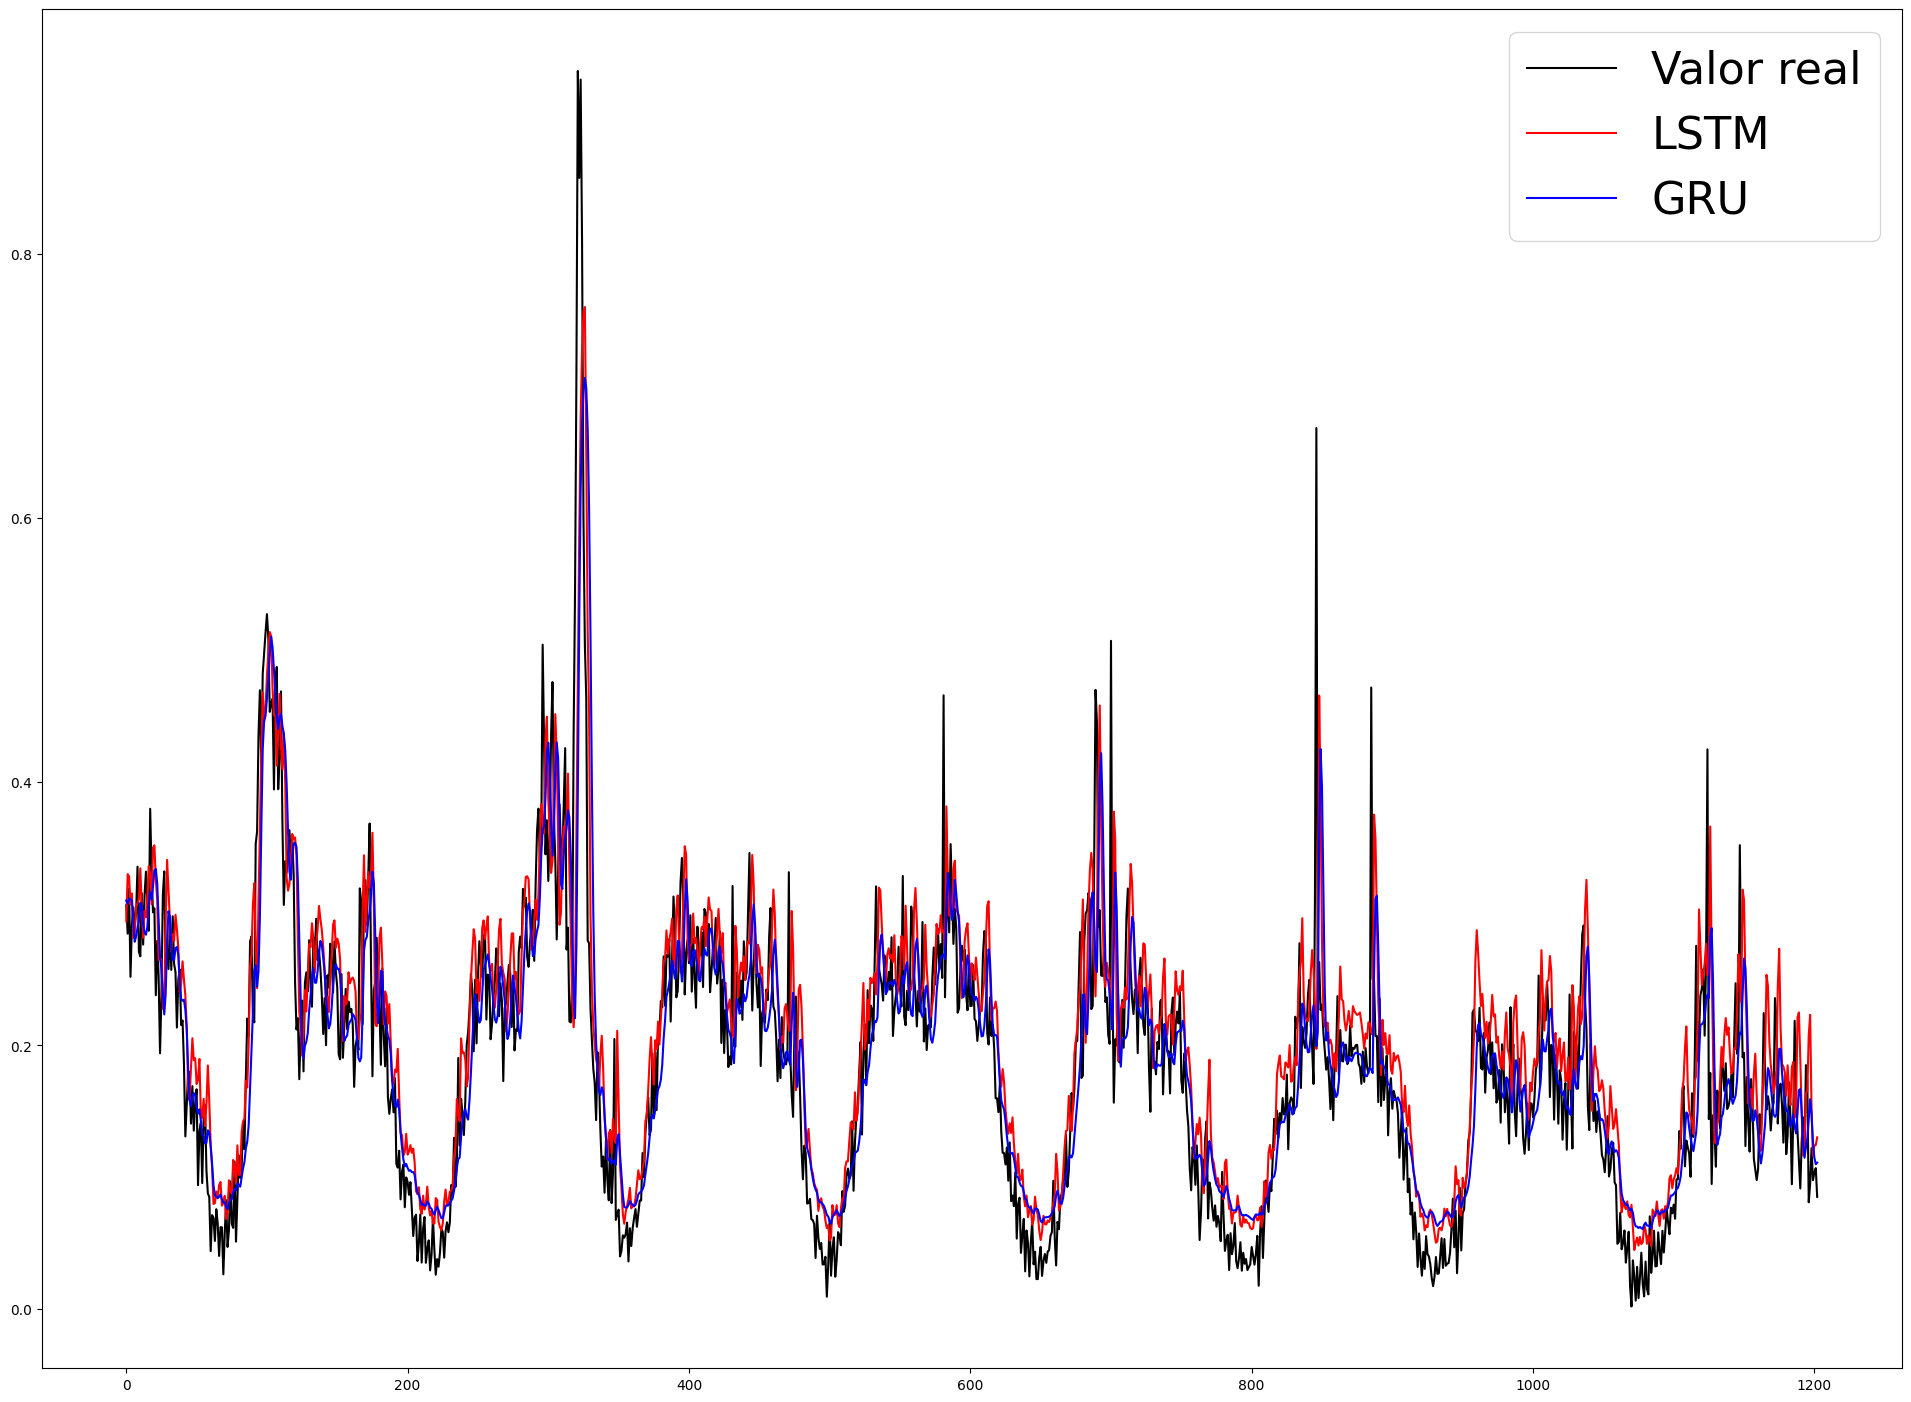

In [131]:
plt.figure(figsize=(24, 18), dpi=100) 
real, = plt.plot(y_val_uni, color='k')
glstm, = plt.plot(test_predictions_lstm_m_s, color='r')
ggru, = plt.plot(test_predictions_gru_m_s, color='b')

plt.legend([real, glstm, ggru], ["Valor real", "LSTM", "GRU"], prop={'size': 32})

plt.savefig('transformed_data/images/5644-6-0-1-TRPW-sep_LSTM_GRU_COMB.png',bbox_inches='tight')
plt.show()

# Codigo para recuperarse de problemas con GPU

# gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

In [132]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])

IndexError: list index out of range